# 준비 단계

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='-1'


In [ ]:
#@title 패키지 로딩
import sys, os

def _get_available_gpus():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.physical_device_desc for x in local_device_protos if x.device_type == 'GPU']

def _islocal():
    from notebook import notebookapp
    server = next(notebookapp.list_running_servers())
    if server['hostname'] == 'localhost':
        return True
    return False
    
def javascript(*st,file=None):
    from IPython.display import display, HTML
    if len(st) == 1 and file is None:
        s = st[0]
    elif len(st) == 0 and file is not None:
        s = open(file).read()
    else:
        raise ValueError('Pass either a string or file=.')
    display(HTML("<script type='text/javascript'>" + s + "</script>"))

if _islocal():
    import winsound
    print("로컬 실행중")
    print(_get_available_gpus())
    _WORK_PATH = 'Google 드라이브/Projects'
    def alert_short():
        winsound.PlaySound(_WORK_PATH+'/alert_short.wav',winsound.SND_FILENAME)
    
    def alert_long():
        winsound.PlaySound(_WORK_PATH+'/alert_long.wav',winsound.SND_FILENAME)
        
    def notify():
        winsound.PlaySound(_WORK_PATH+'/notify.wav',winsound.SND_FILENAME)

else:
    %tensorflow_version 2.x
    print(_get_available_gpus())
    javascript("""function ClickConnect(){document.querySelector("#connect").click()}setInterval(ClickConnect,60000)""")
    

    from google.colab import drive
    !pip install -q talib-binary
    !pip install -q -U scikit-learn
    !pip install -q pandas-ta
    !pip install -q git+https://github.com/artemmavrin/focal-loss.git
    !pip install -q mplfinance

    drive.mount('/content/drive')
    _WORK_PATH = 'drive/My Drive/Projects'
    

sys.path.insert(0,_WORK_PATH)
from library import *

import talib
import pandas_ta
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import l1_l2, l2, l1
from tensorflow.keras import optimizers, callbacks, layers, regularizers, losses, Model
import random
from mplfinance.original_flavor import candlestick2_ohlc

TensorFlow 2.x selected.
['device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title 프로젝트 설정 

plt.style.use(['dark_background'])
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
pd.set_option('display.float_format', lambda x: '%.5f' % x)
plt.rcParams.update({
    'axes.xmargin': 0.001,
    'axes.ymargin': 0.001,
    'figure.dpi' : 80,
    'figure.figsize': (12, 6)
    })
# np.set_printoptions(formatter={'all':lambda x: str(x)})

# 프로젝트 설정
PROJECT_NAME = 'v3 1h' #@param {type:'string'}
TEST_NAME = '05 test2' #@param {type:'string'}
PERIOD = '1h' #@param ['1m', '3m', '5m', '15m', '30m', '1h', '1d']
PROJECT_PATH = os.path.join(_WORK_PATH, PROJECT_NAME) + '/'
TEST_PATH = os.path.join(_WORK_PATH, PROJECT_NAME, TEST_NAME) + '/'
FIG_PATH = os.path.join(TEST_PATH, 'figure') + '/'
FIG_PREDICT = os.path.join(TEST_PATH, 'predict') + '/'

# 학습 설정
TRAIN_LENGTH= 5000  #@param {type:'number'}
VAL_LENGTH  = 1000  #@param {type:'number'}
TEST_LENGTH = 5000  #@param {type:'number'}
PRED_LENGTH = 60    #@param {type:'number'}
TIMESTEP =  60     #@param {type:'number'}

# 변수명 축약
HLC = ['high','low','close']
HLCV = ['high','low','close','volume']
OHLCV = ['open', 'high','low','close','volume']
OHLC = ['open', 'high','low','close']
# 고정 변수
BATCH_SIZE = 1 


FILE_MODEL  = TEST_PATH+'train.h5'
FILE_CHECKPOINT = TEST_PATH+'{epoch:03d}_{loss:.6f}_{val_loss:.6f}.h5'

FILE_SCALER = TEST_PATH+'train.scaler'
FILE_LOG    = TEST_PATH+'train.log'
FILE_FEATURE_LOG = TEST_PATH+'feature.log'
FILE_RAW    = PROJECT_PATH + 'raw.csv'

text_curr = colored('현재', 'yellow')
text_close = colored('예상', 'cyan')
text_sell = colored('상단', 'red')
text_buy = colored('하단', 'green')
text_up = colored('롱', 'green')
text_dn = colored('숏', 'red')
REFRESH_TIMER = 60

FEATURE_LIST =  'bclose bhigh blow bclosema badx batr bcci bdema bkama bmacd bmacdf bmom brsi bskew btrix btsf bstddev bwma bwillr bnatr bsma bzscore bqstick bkurtosis bmstoch close high low volume closema adosc adx atr cci dema dx kama macd macdf mom mfi pvt rsi skew trix tsf stddev wma willr natr sma zscore qstick kurtosis mstoch'.split(' ')
#중요 cci low qstick willr closema adx rsi stochf wma adosc
#별로 kama volume macdf close sma pvt cmf 

if not os.path.isdir(TEST_PATH):
    print('저장 폴더생성:', TEST_PATH)
    os.makedirs(TEST_PATH)
    os.makedirs(FIG_PATH)
    os.makedirs(FIG_PREDICT)
else:
    print('저장 폴더 존재:', TEST_PATH)

def cscheme(colors):
    aliases = {
        'hlc':['r', 'g', 'k'],
    }
    aliases['default'] = aliases['gr']
    return aliases[colors]

저장 폴더 존재: drive/My Drive/Projects/v3 1h/05 test2/


In [ ]:
#@title 데이터 불러오기
OVERWRITE = False #@param {type:"boolean"}

# 비트맥스에서 데이터 받아오기
if not os.path.isfile(FILE_RAW) or OVERWRITE:
    print('데이터 받아오는중...')
    signal_data = get_datas(count=25500, period=PERIOD, end='2020-02-21') # Maximum 75만개

    print('데이터 저장', FILE_RAW)
    signal_data.to_csv(FILE_RAW, index=False)

# 데이터 파일 불러오기
else:
    print('데이터 파일 존재', FILE_RAW)
    signal_data = pd.read_csv(FILE_RAW)

# 점검? volume 0 제거
signal_data = signal_data.loc[signal_data.volume!=0]

#데이터 파일 출력
display(signal_data)

print(signal_data.datetime.iloc[0], signal_data.datetime.iloc[-1])


데이터 파일 존재 drive/My Drive/Projects/v3 1h/raw.csv


,datetime,open,high,low,close,volume,bopen,bhigh,blow,bclose
0,2017-03-25 15:00,900.37000,913.00000,898.12000,902.00000,2747475,901.00000,914.50000,901.00000,902.00000
1,2017-03-25 16:00,902.00000,909.00000,896.07000,900.10000,1826533,902.00000,909.00000,899.00000,901.00000
2,2017-03-25 17:00,900.10000,936.36000,899.50000,928.00000,4222380,901.00000,938.50000,901.00000,930.50000
3,2017-03-25 18:00,928.00000,929.49000,889.88000,890.38000,3183866,930.50000,931.50000,892.00000,892.00000
4,2017-03-25 19:00,890.38000,918.33000,890.38000,916.78000,3540277,892.00000,917.50000,893.00000,917.50000
...,...,...,...,...,...,...,...,...,...,...
25495,2020-02-20 20:00,9610.00000,9641.50000,9582.50000,9612.00000,98416369,9604.00000,9636.50000,9577.00000,9606.00000
25496,2020-02-20 21:00,9612.00000,9636.50000,9562.00000,9577.00000,87109461,9606.00000,9632.50000,9562.50000,9570.50000
25497,2020-02-20 22:00,9577.00000,9606.50000,9545.00000,9565.00000,102926134,9570.50000,9601.00000,9541.50000,9564.00000
25498,2020-02-20 23:00,9565.00000,9601.50000,9541.00000,9599.00000,151186549,9564.00000,9595.00000,9532.50000,9595.00000


2017-03-25 15:00 2020-02-21 00:00


In [ ]:
#@title Xlist
xlist = '''
bclosema_15
bdema_120
bdema_13
bdema_16
bdema_2
bdema_21
bdema_6
bdema_91
bmacdf_40
brsi_21
brsi_27
bsma_20
bsma_35
bsma_60
bwma_5
bwma_8
close_2
closema_25
closema_30
closema_4
closema_66
closema_79
closema_84
dema_11
dema_14
dema_2
high_10
kama_4
low_10
pvt_27
pvt_60
rsi_12
rsi_19
rsi_20
tsf_113
tsf_120
tsf_20
tsf_55
willr_42
wma_25
'''.strip('\n').split('\n')



xlist = [x.strip(' ') for x in xlist]
print('길이:',len(xlist))
xlist = list(dict.fromkeys(xlist))
print('중복제거:',len(xlist))
# xlist.sort()
xlist

 # mfi_244:10 stochf_16:7 qstick_266:7 mfi_250:7 rsi_4:6 closema_4:6 rsi_298:6 kama_13:6 mfi_75:6 atr_245:6 willr_113:6 stddev_49:6 rsi_263:6 willr_118:6

길이: 40
중복제거: 40


['bclosema_15',
 'bdema_120',
 'bdema_13',
 'bdema_16',
 'bdema_2',
 'bdema_21',
 'bdema_6',
 'bdema_91',
 'bmacdf_40',
 'brsi_21',
 'brsi_27',
 'bsma_20',
 'bsma_35',
 'bsma_60',
 'bwma_5',
 'bwma_8',
 'close_2',
 'closema_25',
 'closema_30',
 'closema_4',
 'closema_66',
 'closema_79',
 'closema_84',
 'dema_11',
 'dema_14',
 'dema_2',
 'high_10',
 'kama_4',
 'low_10',
 'pvt_27',
 'pvt_60',
 'rsi_12',
 'rsi_19',
 'rsi_20',
 'tsf_113',
 'tsf_120',
 'tsf_20',
 'tsf_55',
 'willr_42',
 'wma_25']

In [ ]:
#@title 데이터 처리함수
from scipy.stats import mstats
from scipy.stats import kurtosis as kurt
from IPython.display import HTML as html_print
from IPython.display import display

def print_color(t):
    def cstr(s, color='white'):
        return "<font size=7, text style=color:{}>{}</text>".format(color, s)
    display(html_print(' '.join([cstr(ti, color=ci) for ti, ci in t])))

#@title 지표 및 X, Y 생성 함수
def create_dataset(df, timestep = 1, x_list = None, y_list = None):
    # df = data.copy()
    dataX, dataY = [], []

    # 타임스탭 배열 만들기
    for i in range(timestep, len(df)+1):
        dataX.append(df[x_list].values[i-timestep:i])
        dataY.append(df[y_list].values[i-1])
    return np.asarray(dataX), np.asarray(dataY)

def macd_stoch(data, fast=23, slow=50, length=10):
    MACD = data.rolling(fast).mean() - data.rolling(slow).mean()
    STOK = ((MACD - MACD.rolling(window=length).min()) / (MACD.rolling(window=length).max() - MACD.rolling(window=length).min()))
    return STOK.fillna(0)

def fstoch(data, length=15):
    fstoch = ((data - data.rolling(window=length).min().shift(-length+1)) / 
            (data.rolling(window=length).max().shift(-length+1) - data.rolling(window=length).min().shift(-length+1)))
    return fstoch
        
def zigzag(s, pct=0.5):
    thres_up = 1 + pct / 100
    thres_dn = 1 - pct / 100

    last_index = s.index[0]
    last_price = s.close[last_index]
    c_trend = None

    zig_index, zig_price, zig_trend = [last_index], [last_price], []

    for c_index, c_high, c_low in zip(s.index, s.high, s.low):
        # No initial c_trend
        if c_trend is None:
            if c_high / last_price > thres_up:
                last_index = c_index
                last_price = c_high
                c_trend = 1
                zig_trend.append(-1)

            elif c_low / last_price < thres_dn:
                last_index = c_index
                last_price = c_low
                c_trend = -1
                zig_trend.append(1)

        # Trend is up
        elif c_trend == 1:
            # New high
            if c_high > last_price:
                last_index, last_price = c_index, c_high
            # Reversal
            elif c_low / last_price < thres_dn:
                zig_trend.append(c_trend)
                zig_index.append(last_index)
                zig_price.append(last_price*0.999)

                c_trend, last_index, last_price = -1, c_index, c_low
        # Trend is down
        else:
            # New low
            if c_low < last_price:
                last_index, last_price = c_index, c_low
            # Reversal
            elif c_high / last_price > thres_up:
                zig_trend.append(c_trend)
                zig_index.append(last_index)
                zig_price.append(last_price*1.001)

                c_trend, last_index, last_price = 1, c_index, c_high

    # Extrapolate the current c_trend
    if zig_index[-1] != s.index[-1]:
        zig_index.append(s.index[-1])
        zig_trend.append(c_trend)

        if c_trend is None:
            zig_price.append(s.close[zig_index[-1]])
        elif c_trend == 1:
            zig_price.append(s.high[zig_index[-1]])
        else:
            zig_price.append(s.low[zig_index[-1]])
    
    data = {"trend":zig_trend, "zig":zig_price}
    
    return pd.DataFrame(data, index=zig_index)

def gen_xlist(start=2, stop=100, step=10):
    r = []
    for f in FEATURE_LIST:
        for i in range(start, stop, step):
            k = f'{f}_{i}'
            r.append(k)
    return r

def var_importance(model, gen, xlist, batch_size):
    start = random.randrange(0, len(gen)-100, 100)
    x = np.concatenate([gen[i][0] for i in range(start, start+100)]) # all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 88 has 1 dimension(s
    model.reset_states()
    orig_out = model.predict(x, batch_size=batch_size)[0]
    effect = [0] * len(xlist)
    for i in range(len(xlist)):  # iterate over the three features
        # print(i)
        new_x = x.copy()
        perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        model.reset_states()
        perturbed_out = model.predict(new_x, batch_size=batch_size)[0]
        effect[i] = (((orig_out - perturbed_out) ** 2).mean() ** 0.5)
        
    return pd.Series(effect, index=xlist)

def perm_xlist(xlist, step=1):

    r=[]
    max_n = 0
    for x in xlist:
        r.append(x)
        try:
            f, n = x.split('_')
        except:
            continue
        n = int(n)
        # max_n = max(n, max_n)
        for i in range(step):
            p = random.randrange(max(2, n-10), n+10, 1)
            k = f'{f}_{p}'
            r.append(k)

    for n in range(step):
        for f in FEATURE_LIST:
            i = random.randrange(2, 300, 1)
            k = f'{f}_{i}'
            r.append(k)

    return list(dict.fromkeys(r))

# clear = callbacks.LambdaCallback(on_epoch_begin=lambda epoch, logs: clear_output() if (epoch+1)%50==0 else None)

#@title 모델 생성 및 콜백
class CrossLearnCallback(callbacks.Callback):
    def __init__(self, generator=None, target=None, patience=0, name='', reset_weight=True):
        super(CrossLearnCallback, self).__init__()
        self.generator = generator
        self.gen_length = generator.length      # 타임 스텝 길이
        self.fixed_length = len(generator)      # 한번에 사용되는 길이 (고정된 generator 길이)
        self.data_length = len(generator.data)  # 전체 데이터 길이
        self.name = name
        self.weight = None
        self.target= target
        self.patience  = patience
        self.reset_weight = reset_weight

    def on_train_begin(self, logs):
        # wait 초기화
        self.wait = 0
        
        # optimizer 초기 weight 받아오기
        self.model.optimizer.get_updates(params=self.model.trainable_weights, loss=self.model.total_loss)
        self.weight= model.optimizer.get_weights()

        target_range = None
        if self.target : target_range = range(self.target.start_index, self.target.end_index)
        
        while True:
            start = random.randrange(self.gen_length, self.data_length-(self.data_length%self.fixed_length)-self.fixed_length, self.fixed_length)
            end = start + self.fixed_length-1

            if target_range:
                if start in target_range or end in target_range: continue
            break

        self.generator.start_index = start
        self.generator.end_index = end
        print(f'{self.name}_range : ', f'{self.generator.start_index}:{self.generator.end_index}')

    # def on_epoch_end(self, epoch, logs):
    #     logs[f'{self.name}_range'] = f'{self.generator.start_index}:{self.generator.end_index}'

    def on_epoch_end(self, epoch, logs):
        logs[f'{self.name}_range'] = f'{self.generator.start_index}:{self.generator.end_index}'
        self.wait += 1
        if self.wait >= self.patience:
            self.wait = 0

            old_range = range(self.generator.start_index, self.generator.end_index)
            if self.target : target_range = range(self.target.start_index, self.target.end_index)
            
            while True:
                start = random.randrange(self.gen_length, self.data_length-(self.data_length%self.fixed_length), self.fixed_length)
                end = start + self.fixed_length-1

                if start in old_range or end in old_range: continue
                if target_range:
                    if start in target_range or end in target_range: continue
                break
            
            # self.model.optimizer.set_weights(np.power(model.optimizer.get_weights(),2))
            if self.reset_weight : self.model.optimizer.set_weights(self.weight)

            self.generator.start_index = start
            self.generator.end_index = end

            print(f'\n{self.name}_range : ', f'{self.generator.start_index}:{self.generator.end_index}')

clear = callbacks.LambdaCallback(on_epoch_begin=lambda epoch, logs: clear_output() if (epoch+1)%50==0 else None)


def input_loss(x_input):
    def loss(y_true,y_pred):
        return K.mean( K.square(y_pred - y_true) - K.square(y_true - x_input[:,:,-1:]), axis=-1)        # 2번 x_input[:,:,-3:]
    return loss

def sample_normalize(x, _eps=1e-5):
    m = K.mean(x, axis=-1, keepdims=True)
    std = K.sqrt(K.var(x, axis=-1, keepdims=True) + _eps)
    return (x-m)/ (std+_eps)

def log_loss(w):
    def loss(y_true, y_pred):
        return w*tf.math.log1p(losses.mean_squared_error(y_true, y_pred))
    return loss

def noise_loss(stddev):
    def loss(y_true, y_pred):
        rand = K.random_normal((1,),stddev=stddev) +1 
        return tf.losses.binary_crossentropy(y_true, y_pred) * rand
    return loss

def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# class CustomGen(TimeseriesGenerator):
#   def __getitem__(self, idx):
#     x,y = super().__getitem__(idx)
#     # do processing here

#     return x, (y[:,0],y[:,1])

# class FixedTimeseriesGenerator(TimeseriesGenerator):
#     def __init__(self, fixed_length = 100, **kwargs):
#         end_index=fixed_length+kwargs['length']-1
#         if end_index > len(kwargs['data']):
#             raise Exception('Out of data length')
#         super().__init__(**kwargs, end_index=fixed_length+kwargs['length']-1)

# import tensorflow as tf


def smooth_l1(sigma=3.0):
	""" Create a smooth L1 loss functor.
	Args
		sigma: This argument defines the point where the loss changes from L2 to L1.
	Returns
		A functor for computing the smooth L1 loss given target data and predicted data.
	"""
	sigma_squared = sigma ** 2

	def _smooth_l1(y_true, y_pred, **kwargs):
		""" Compute the smooth L1 loss of y_pred w.r.t. y_true.
		Args
			y_true: Tensor from the generator of shape (B, N, 5). The last value for each box is the state of the anchor (ignore, negative, positive).
			y_pred: Tensor from the network of shape (B, N, 4).
		Returns
			The smooth L1 loss of y_pred w.r.t. y_true.
		"""
		# Separate target and state.
		regression        = y_pred
		regression_target = y_true[:, :, :4]
		anchor_state      = y_true[:, :, 4]

		# Filter out "ignore" anchors.
		indices           = tf.where(tf.keras.backend.equal(anchor_state, 1))
		regression        = tf.gather_nd(regression, indices)
		regression_target = tf.gather_nd(regression_target, indices)

		# Compute smooth L1 loss
		# f(x) = 0.5 * (sigma * x)^2          if |x| < 1 / sigma / sigma
		#        |x| - 0.5 / sigma / sigma    otherwise
		regression_diff = regression - regression_target
		regression_diff = tf.keras.backend.abs(regression_diff)
		regression_loss = tf.where(
			tf.keras.backend.less(regression_diff, 1.0 / sigma_squared),
			0.5 * sigma_squared * tf.keras.backend.pow(regression_diff, 2),
			regression_diff - 0.5 / sigma_squared
		)

		# compute the normalizer: the number of positive anchors
		normalizer = tf.keras.backend.maximum(1, tf.keras.backend.shape(indices)[0])
		normalizer = tf.keras.backend.cast(normalizer, dtype=tf.keras.backend.floatx())
		return tf.keras.backend.sum(regression_loss) / normalizer

	return _smooth_l1


class PriorProbability(tf.keras.initializers.Initializer):
	""" Apply a prior probability to the weights.
	"""

	def __init__(self, probability=0.01):
		self.probability = probability

	def get_config(self):
		return {
			'probability': self.probability
		}

	def __call__(self, shape, dtype=None):
		# Set bias to -log((1 - p)/p) for foreground.
		if dtype is not None:
			dtype = dtype.as_numpy_dtype()
		result = np.ones(shape, dtype=dtype) * -math.log((1 - self.probability) / self.probability)

		return result

In [ ]:
#@title 모델 및 지표 생성

def create_features(df, xlist = None, log=False, test=False):
    ylist = []
    dummy = []
    df = df.reset_index(drop=True)

    # bxbt
    def bclose(i):   return df.bclose.pct_change(i)
    def bhigh(i):    return df.bhigh/df.bclose.rolling(i).mean()
    def blow(i):     return df.blow/df.bclose.rolling(i).mean()
    def bclosema(i): return df.bclose/df.bclose.rolling(i).mean()

    def badx(i):     return talib.ADX(df.bhigh, df.blow, df.bclose, i)
    def batr(i):     return talib.ATR(df.bhigh, df.blow, df.bclose, i)
    def bcci(i):     return talib.CCI(df.bhigh, df.blow, df.bclose, i)
    def bdema(i):    return df.bclose/talib.DEMA(df.bclose, i) #pct 변경
    def bkama(i):    return df.bclose/talib.KAMA(df.bclose, i) # pct 변경
    def bmacd(i):    return talib.MACD(df.bclose, i, i*2, max(int(0.75*i),2))[0]
    def bmacdf(i):   return talib.MACD(df.bclose, i, i*2, max(int(0.75*i),2))[0] - talib.MACD(df.bclose, i, i*2, max(int(0.75*i),2))[1]
    def bmom(i):     return talib.MOM(df.bclose, i)
    def brsi(i):     return talib.RSI(df.bclose, i)
    def bskew(i):    
        if i<3 : return None
        return df.ta.skew(length=i, close='bclose')
    def btrix(i):    return talib.TRIX(df.bclose, i)
    def btsf(i):     return df.bclose/talib.TSF(df.bclose, i) # pct 변경
    def bstddev(i):  return talib.STDDEV(df.bclose, i)
    def bwma(i):     return df.bclose/talib.WMA(df.bclose, i) # pct 변경
    def bwillr(i):   return talib.WILLR(df.bhigh, df.blow, df.bclose, i)
    # def bstochf(i):  return talib.STOCHF(df.bhigh, df.blow, df.bclose, i, max(int(i*0.6),3))[0]

    def bnatr(i):    return talib.NATR(df.bhigh, df.blow, df.bclose, i)
    def bsma(i):     return talib.SMA(df.bclose, i).pct_change(i)
    def bzscore(i):  
        if i<9 : return None
        return df.ta.zscore(length=i, close='bclose')
    def bqstick(i):  return df.ta.qstick(length=i, open='bopen', close='bclose')
    def bkurtosis(i):return df.bclose.rolling(i).apply(lambda x: kurt(x, bias=False), raw=True)
    def bmstoch(i):  return macd_stoch(df.bclose, i, i*2, max(int(i*0.6),2))

    # original
    def close(i):   return df.close.pct_change(i)
    def high(i):    return df.high/df.close.rolling(i).mean()
    def low(i):     return df.low/df.close.rolling(i).mean()
    def volume(i):  return df.volume/df.volume.rolling(i).mean()
    def closema(i): return df.close/df.close.rolling(i).mean()

    def adosc(i):   return talib.ADOSC(df.high, df.low, df.close, np.log1p(df.volume), i, i+7)  # 너무 크면 오류 max값 제한하기
    def adx(i):     return talib.ADX(df.high, df.low, df.close, i)
    def atr(i):     return talib.ATR(df.high, df.low, df.close, i)
    # def cmf(i):     return df.ta.cmf(length=i)
    def cci(i):     return talib.CCI(df.high, df.low, df.close, i)
    def dema(i):    return df.close/talib.DEMA(df.close, i) #pct 변경
    def dx(i):      return talib.DX(df.high, df.low, df.close, i)                   # 너무 크면 오류 max값 제한 하기
    def kama(i):    return df.close/talib.KAMA(df.close, i) # pct 변경
    def macd(i):    return talib.MACD(df.close, i, i*2, max(int(0.75*i),2))[0]
    def macdf(i):   return talib.MACD(df.close, i, i*2, max(int(0.75*i),2))[0] - talib.MACD(df.close, i, i*2, max(int(0.75*i),2))[1]
    def mom(i):     return talib.MOM(df.close, i)
    def mfi(i):     return talib.MFI(df.high, df.low, df.close, df.volume, i)
    def pvt(i):     return talib.ROCR(df.close, i) * np.log1p(df.volume)
    def rsi(i):     return talib.RSI(df.close, i)
    def skew(i):    
        if i<3 : return None
        return df.ta.skew(length=i)
    def trix(i):    return talib.TRIX(df.close, i)
    def tsf(i):     return df.close/talib.TSF(df.close, i) # pct 변경
    def stddev(i):  return talib.STDDEV(df.close, i)
    def wma(i):     return df.close/talib.WMA(df.close, i) # pct 변경
    def willr(i):   return talib.WILLR(df.high, df.low, df.close, i)
    # def stochf(i):  return talib.STOCHF(df.high, df.low, df.close, i, max(int(i*0.6),3))[0]
    def natr(i):    return talib.NATR(df.high, df.low, df.close, i)
    def sma(i):     return talib.SMA(df.close, i).pct_change(i)
    def zscore(i):  
        if i<9 : return None
        return df.ta.zscore(length=i)
    def qstick(i):  return df.ta.qstick(length=i)
    def kurtosis(i):return df.close.rolling(i).apply(lambda x: kurt(x, bias=False), raw=True)
    def mstoch(i):  return macd_stoch(df.close, i, i*2, max(int(i*0.6),2))

    dic = locals()
    if log:print ('{:=^32}'.format(' Indicators '))
    result = []
    for x in xlist:
        try:
            f, n = x.split('_')
        except ValueError:
            print('오류:', x)
            continue
        r = eval(f+'('+n+')', dic)
        if r is None:
            continue
        if log:print(x, end=' ')
        r = r.rename(x)
        df = df.join(r)
        result.append(x)
    print()
    ####################################################
    if log:print ('{:=^32}'.format(' X '))
    
    xlist = result
 
    # df['xclose'] = df.close.rolling(SMOOTH, center=True, win_type='triang', min_periods=1).mean()
    # df['xhigh'] = df.xclose.rolling(SHIFT, min_periods=1).max()/df.close-1
    # df['xlow'] = df.xclose.rolling(SHIFT, min_periods=1).min()/df.close-1

    # xlist.extend(['xclose', 'xhigh', 'xlow'])
    
    # if log:print(' '.join(xlist))
    ####################################################
    if log:print ('{:=^32}'.format(' Y '))

    df['ybase'] = df.close.rolling(120).mean()
    dummy.append('ybase')

    # 지그재그
    if not test:
        zig_df = zigzag(df, pct=1)
        zig_high = zig_df.loc[zig_df['trend']==1].drop('trend', axis=1).add_suffix('_high')
        zig_low = zig_df.loc[zig_df['trend']==-1].drop('trend', axis=1).add_suffix('_low')
        df['yhigh'] =  zig_high
        df['ylow'] = zig_low

        df['yhigh'] = df.yhigh.interpolate(method='bfill').shift(-1)/df.close.rolling(120).mean()
        df['ylow'] = df.ylow.interpolate(method='bfill').shift(-1)/df.close.rolling(120).mean()

        ################################################
        
        ylist.extend(['yhigh', 'ylow'])
       
    if log:print(' '.join(ylist))
    
    #####################################################
    if log:print ('{:=^32}'.format(' Result '))
    if log:print('Total Features:', len(xlist))
    if log:print('Input Length:', len(df))

    df = df[OHLC+xlist+dummy+ylist + ['bhigh','blow','bclose','bopen']]

    valid_start = 0
    for x in xlist:
        valid_start = max(df[x].first_valid_index(),valid_start)
    df = df[valid_start:]
    if log:print('Dropped Length:', valid_start)
    if log:print('Result Length:', len(df))

    if log:print('=========== Na 체크 ============')
    if log:print_pd(df.isnull().sum(axis = 0).loc[df.isnull().sum(axis = 0) !=0])
    if log:print ('================================')

    return df.reset_index(drop=True), xlist, ylist

from tensorflow.keras.constraints import max_norm, unit_norm

class TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
    def __init__(self, reset_states = False, *args, **kwargs):
        self.reset_states = reset_states
        super(TimeseriesGenerator, self).__init__(*args, **kwargs)

    def __getitem__(self, index):
        # weight = np.array([(np.arange(TIMESTEP)/(TIMESTEP-1)+0.5)**2*5])
        # weight = np.array([(np.arange(TIMESTEP)/(TIMESTEP-1)+0.5)[::-1]**1.1])

        weight = np.array([np.ones(TIMESTEP)])
        weight[0,-2:] = 10
        # weight = np.reshape(weight, (1,60,1))

        if self.shuffle:
            rows = np.random.randint(self.start_index, self.end_index + 1, size=self.batch_size)
        else:
            i = self.start_index + self.batch_size * self.stride * index
            rows = np.arange(i, min(i + self.batch_size * self.stride, self.end_index + 1), self.stride)
        
        samples = np.array([self.data[row - self.length:row:self.sampling_rate] for row in rows])
        targets = np.array([self.targets[row - self.length:row:self.sampling_rate] for row in rows]) # many to many
        # targets = np.array([self.targets[row] for row in rows]) 

        if self.reverse:
            return samples[:, ::-1, ...], targets[:, ::-1, ...]

        if self.reset_states:
            model.reset_states()
            # model.predict()

        return samples, targets, weight

    def __len__(self):
        # return (self.end_index - self.start_index + (self.batch_size * self.stride) - ((self.end_index-self.start_index) %(self.batch_size*self.stride) + self.batch_size*self.stride)) // (self.batch_size * self.stride) 
        return (self.end_index - self.start_index + self.batch_size * self.stride) // (self.batch_size * self.stride) #+ 1

def i_loss(y_true, y_pred):
    return tf.metrics.mse(y_true[:,-2:], y_pred[:,-2:])

def create_model(lr=0.00004, batch_size = BATCH_SIZE, timestep = TIMESTEP, x_num = 1, y_num = 1):
    K.clear_session()
    gc.collect()
    
    ### Inputs
    inputs = layers.Input(shape=(timestep, x_num), batch_size=batch_size)
    r_inputs = layers.Lambda(lambda x : K.reverse(x , axes=1))(inputs)

    ## Layers
    x = layers.Conv1D(80, 3, strides=1, padding='same', activation='relu', bias_regularizer=l1_l2(0.05) )(inputs)
    x = layers.Conv1D(80, 3, strides=1, padding='same', activation='relu', bias_regularizer=l1_l2(0.05) )(x)
    x = layers.GaussianDropout(0.4)(x)

    x1 = layers.Conv1D(80, 3, strides=1, padding='same', activation='relu', bias_regularizer=l1_l2(0.05) )(r_inputs)
    x1 = layers.Conv1D(80, 3, strides=1, padding='same', activation='relu', bias_regularizer=l1_l2(0.05) )(x1)
    x1 = layers.GaussianDropout(0.4)(x1)
    x = layers.Concatenate()([x, x1])

    x = layers.Bidirectional( layers.GRU(320, stateful=True, return_sequences=True, dropout=0.4, ) ) (x)
    x = layers.Bidirectional( layers.GRU(320, stateful=True, return_sequences=True, dropout=0.4, ) ) (x)
    x = layers.Bidirectional( layers.GRU(320, stateful=True, return_sequences=True, dropout=0.4, ) ) (x)
    x = layers.Bidirectional( layers.GRU(320, stateful=True, return_sequences=True, dropout=0.4, ) ) (x)
    x = layers.Bidirectional( layers.GRU(320, stateful=True, return_sequences=True, dropout=0.4, ) ) (x)
    x = layers.GaussianDropout(0.4)(x)    
    
    
    
    #### Outputs
    output = layers.TimeDistributed( layers.Dense(2, activation='linear',  bias_regularizer=l1_l2(0.01) ))(x)

    model = Model(inputs=inputs, outputs = output)
    model.compile(optimizer=optimizers.Nadam(learning_rate=lr), loss='mse', metrics=[i_loss], sample_weight_mode='temporal') # [lmse(3),lmse(2)]  sample_weight_mode='temporal'
    return model

model = create_model(x_num=len(xlist))
model.summary()
# 1632 1514


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, 60, 40)]        0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (1, 60, 40)          0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (1, 60, 80)          9680        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (1, 60, 80)          9680        lambda[0][0]                     
______________________________________________________________________________________________

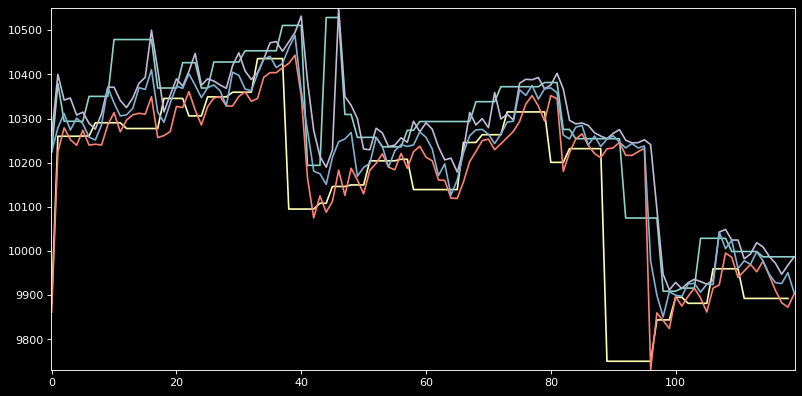

In [ ]:
df = signal_data[-120:].copy().reset_index(drop=True)
zig_df = zigzag(df, pct=.5)
zig_high = zig_df.loc[zig_df['trend']==1].drop('trend', axis=1).add_suffix('_high')
zig_low = zig_df.loc[zig_df['trend']==-1].drop('trend', axis=1).add_suffix('_low')

df['yhigh'] =  zig_high
df['ylow'] = zig_low

df['yhigh'] = df.yhigh.interpolate(method='bfill', order=3 )
df['ylow'] = df.ylow.interpolate(method='bfill')

plt.plot(df.yhigh)
plt.plot(df.ylow)
plt.plot(df.high)
plt.plot(df.low)
plt.plot(df.close)


# df['yhigh'] = df.close.rolling(10).max().shift(-10)
# df['ylow'] = df.close.rolling(10).min().shift(-10)
# df['yclose'] = df.close.rolling(10, center=True).median().shift(-10)

# df['yzig'] = zig(df.close, ratio=0.005, depth=0, extend_to_last=True)
# df['yzig'] = df.yzig.interpolate(method='linear').shift(-5)

# df[['yhigh', 'ylow', 'yzig', 'close']].plot(figsize=(14,8))

# 학습

In [ ]:
#@title 데이터 준비
df, xlist, ylist = create_features(signal_data[-1500000:],xlist,True)
df = df[400:-10]

# df[-120:][ylist+['yclose']].plot()
# plt.show()

# # 스케일링
xscaler = preprocessing.RobustScaler(quantile_range=(1,99))
yscaler = preprocessing.RobustScaler(quantile_range=(1,99))

# x
df[xlist] = xscaler.fit_transform(df[xlist])
df[xlist] = np.clip(df[xlist], -1, 1)

#y
yscaler.fit(np.expand_dims(df[ylist].values.flatten(),1))
df[ylist] = yscaler.transform(df[ylist])
df[ylist] = np.clip(df[ylist], -1, 1)

print_pd(df[xlist+ylist].agg(['min', 'max', 'mean','std']))

# save
joblib.dump([xlist, xscaler, yscaler], FILE_SCALER)

========== Indicators ==========
bclosema_15 bdema_120 bdema_13 bdema_16 bdema_2 bdema_21 bdema_6 bdema_91 bmacdf_40 brsi_21 brsi_27 bsma_20 bsma_35 bsma_60 bwma_5 bwma_8 close_2 closema_25 closema_30 closema_4 closema_66 closema_79 closema_84 dema_11 dema_14 dema_2 high_10 kama_4 low_10 pvt_27 pvt_60 rsi_12 rsi_19 rsi_20 tsf_113 tsf_120 tsf_20 tsf_55 willr_42 wma_25 
============== X ===============
============== Y ===============
yhigh ylow
============ Result ============
Total Features: 40
Input Length: 25496
Dropped Length: 238
Result Length: 25258
=========== Na 체크 ============


yhigh    5
ylow     1
dtype: int64

,bclosema_15,bdema_120,bdema_13,bdema_16,bdema_2,bdema_21,bdema_6,bdema_91,bmacdf_40,brsi_21,brsi_27,bsma_20,bsma_35,bsma_60,bwma_5,bwma_8,close_2,closema_25,closema_30,closema_4,closema_66,closema_79,closema_84,dema_11,dema_14,dema_2,high_10,kama_4,low_10,pvt_27,pvt_60,rsi_12,rsi_19,rsi_20,tsf_113,tsf_120,tsf_20,tsf_55,willr_42,wma_25,yhigh,ylow
min,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-0.83358,-0.86658,-0.90116,-0.85395,-0.62964,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-0.90825,-1.00000,-1.00000,-1.00000,-1.00000,-0.75459,-0.83009,-0.83920,-0.99392,-0.98466,-1.00000,-0.99651,-0.59557,-1.00000,-0.79316,-1.00000
max,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.85501,0.90714,1.00000,1.00000,0.98642,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.73887,0.82848,0.83806,1.00000,1.00000,1.00000,1.00000,0.47684,1.00000,1.00000,0.71272
mean,0.00072,0.00246,0.00056,0.00068,0.00054,0.00086,0.00012,0.00295,-0.00050,-0.00096,-0.00119,0.00488,0.00695,0.00838,-0.00088,-0.00065,0.00041,0.00196,0.00234,-0.00006,0.00447,0.00487,0.00492,0.00105,0.00103,0.00025,0.03032,-0.00177,-0.03309,-0.01209,0.00130,-0.00159,-0.00143,-0.00189,0.00532,0.00612,0.00240,0.00371,-0.01619,0.00067,0.04455,-0.03674
std,0.16729,0.17374,0.16295,0.16560,0.16440,0.16495,0.16261,0.17318,0.15657,0.20990,0.20920,0.17692,0.18678,0.19319,0.16103,0.16309,0.16146,0.17121,0.17196,0.15917,0.18010,0.18391,0.18542,0.16362,0.16357,0.16249,0.16798,0.16663,0.16926,0.19873,0.19639,0.21586,0.21021,0.20973,0.17554,0.17710,0.16925,0.17389,0.28341,0.16906,0.18795,0.18596


['drive/My Drive/Projects/v3 1h/05 test2/train.scaler']

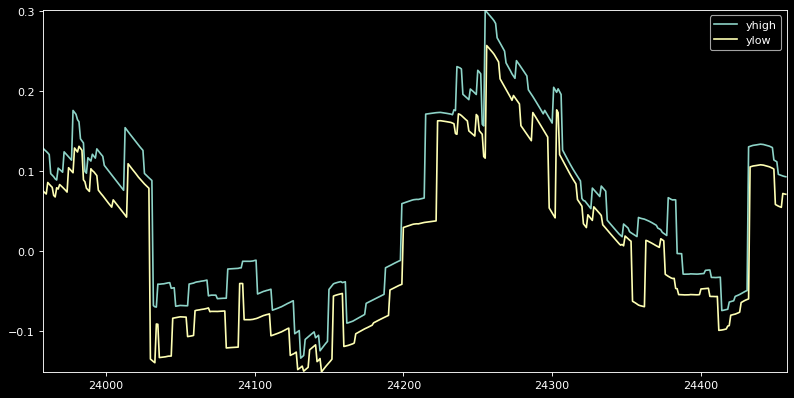

In [ ]:
df[-500:][ylist].plot()
plt.show()


In [ ]:
#@title 학습하기

class RollingCallback(callbacks.Callback):
    def __init__(self, generator=None):
        super(RollingCallback, self).__init__()
        self.generator = generator
        self.length = generator.length      # 타임 스텝 길이
        self.start_index = generator.start_index
        self.end_index = generator.end_index-60

        generator.end_index = generator.end_index-60
    
    def on_epoch_begin(self, epoch, logs):
        # seed =epoch%self.length
        seed = random.randint(1, self.length)
        self.generator.start_index = self.start_index+seed
        self.generator.end_index = self.end_index+seed


TIMESTEP = 60
stride = 60
t = 10
batch_size = 1

train_data = df[:-6500]
train_gen = TimeseriesGenerator(data=train_data[xlist].values, targets=train_data[ylist].values, length=TIMESTEP, stride=stride, batch_size=batch_size, shuffle=False, reverse=False)

# val
val_data = df[-6500:-2500]
val_gen = TimeseriesGenerator(data=val_data[xlist].values, targets=val_data[ylist].values, length=TIMESTEP, stride=stride, batch_size=batch_size, shuffle=False, reverse=False)

# test5
test_data = df[-2500:]
test_gen = TimeseriesGenerator(data=test_data[xlist].values, targets=test_data[ylist].values, length=TIMESTEP, stride=stride, batch_size=batch_size, shuffle=False, reverse=False, reset_states=True)

print('데이터 Legnth', len(train_data), len(val_data), len(test_data))
print('시퀀스 Length', len(train_gen), len(val_gen), len(test_gen))

train_roll = RollingCallback(train_gen)
# val_roll = RollingCallback(train_gen)

csvLogger = callbacks.CSVLogger(TEST_PATH+'train.log', separator='\t', append=True)
rsc = ResetStatesCallback()
mcp = callbacks.ModelCheckpoint(FILE_MODEL, monitor='val_loss', save_best_only=True, verbose=1, save_weights_only=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min', min_lr=0.00000001, min_delta=0)
es = callbacks.EarlyStopping(monitor='val_loss', patience=17, verbose=1, restore_best_weights=True, min_delta=0) 

model = create_model(lr=0.0004, batch_size=batch_size, timestep=TIMESTEP, x_num=len(xlist), y_num=len(ylist))
# model.load_weights(FILE_MODEL)

model.summary()
hist = model.fit(train_gen, validation_data=val_gen, steps_per_epoch=len(train_gen), epochs=1000, verbose=1, callbacks=[rsc, mcp, es, reduce_lr, csvLogger, train_roll])


데이터 Legnth 18348 4000 2500
시퀀스 Length 305 66 41
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, 60, 40)]        0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (1, 60, 40)          0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (1, 60, 80)          9680        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (1, 60, 80)          9680        lambda[0][0]                     
______________________________________________

In [ ]:
#@title 결과확인
TIMESTEP = 60
stride = 60
batch_size = 1

model.load_weights(FILE_MODEL)
test_data = df[-2500:]
test_gen = TimeseriesGenerator(reset_states=False, data=test_data[xlist].values, targets=test_data[ylist].values, length=TIMESTEP, stride=stride, batch_size=batch_size, shuffle=False, reverse=False)
test_pred = model.predict(test_gen)
test_y = np.concatenate([test_gen[i][1] for i in range(len(test_gen))])
    
# print(f'{metrics.mean_squared_error(test_y[:,-10],  test_pred[:,-10]):.4f}, {metrics.r2_score(test_y[:,-10], test_pred[:,-10]):.4f}')

for i in range(1,30):
    print(i)
    print(f'{metrics.mean_squared_error(test_y[:,-i], test_pred[:,-i]):.5f}, {metrics.r2_score(test_y[:,-i], test_pred[:,-i]):.5f}')

# 1
# 0.00247, 0.80814
# 2
# 0.00223, 0.82715
# 3
# 0.00188, 0.86355

1
0.00247, 0.80814
2
0.00223, 0.82715
3
0.00188, 0.86355
4
0.00146, 0.88033
5
0.00174, 0.85576
6
0.00208, 0.82799
7
0.00226, 0.81441
8
0.00245, 0.80716
9
0.00204, 0.85060
10
0.00214, 0.85236
11
0.00183, 0.87830
12
0.00147, 0.91364
13
0.00137, 0.91580
14
0.00117, 0.92899
15
0.00109, 0.93688
16
0.00124, 0.92591
17
0.00133, 0.91889
18
0.00157, 0.88915
19
0.00149, 0.88470
20
0.00158, 0.88000
21
0.00163, 0.86746
22
0.00134, 0.89608
23
0.00164, 0.87823
24
0.00164, 0.88189
25
0.00168, 0.88363
26
0.00176, 0.87318
27
0.00191, 0.85906
28
0.00195, 0.84856
29
0.00204, 0.84318


In [ ]:
from matplotlib.ticker import MultipleLocator

RESULT_PATH = os.path.join(TEST_PATH, 'result') + '/'
if not os.path.isdir(RESULT_PATH): os.makedirs(RESULT_PATH)

TIMESTEP = 60
stride = 60
t = 120
batch_size = 1

test_data = df[-3000:]
test_gen = TimeseriesGenerator(reset_states=False, data=test_data[xlist].values, targets=test_data[ylist].values, length=TIMESTEP, stride=1, batch_size=batch_size, shuffle=False, reverse=False)
for i in range(1,480):

    preds = model.predict(test_gen[i])
    pred_df = test_data[i:60+i]
    preds = yscaler.inverse_transform(preds[0]) * pred_df.ybase[:,None]
    

    ###### 차트 그리기
    # 가격
    fig, ax = plt.subplots(figsize=(8,6))
    draw = 40

    ax.plot(pred_df.high.values[-draw:], c='darkred', alpha=.9)
    ax.plot(pred_df.low.values[-draw:], c='darkgreen', alpha=.9)
    ax.plot(pred_df.close.values[-draw:], c='w', alpha=0.9)

    ax.plot(preds[-draw:,0], c='tab:red', label='High')
    ax.plot(preds[-draw:,1], c='tab:green', label='Low')
    ax.plot(preds[-draw:,:2].mean(axis=1), c='violet', linestyle='--', linewidth=1, label=None)

    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.grid(True,'minor', linestyle=':', linewidth=0.5)
    ax.xaxis.grid(True,'major', linestyle=':', linewidth=2)
    ax.grid(linestyle=':', linewidth=1)
    
    ax.legend(loc='upper left')
    ax.tick_params(labelright=True)
    fig.savefig(RESULT_PATH+str(i), dpi=60)
    plt.close(fig)

In [ ]:
test_data = df[-t*20:]
test_gen = TimeseriesGenerator(data=test_data[xlist].values, targets=test_data[ylist].values, length=TIMESTEP, stride=1, batch_size=batch_size, shuffle=False, reverse=False)
print(len(test_gen))

# 결과확인
model = create_model(timestep=TIMESTEP, x_num=30, y_num=2)
model.load_weights(FILE_MODEL)
model.reset_states()
test_pred = model.predict(test_gen)
test_pred = model.predict(test_gen)

test_y = np.concatenate([test_gen[i][1] for i in range(len(test_gen))])

print(f'{metrics.mean_squared_error(test_y[:,-20], test_pred[:,-20]):.4f}, {metrics.r2_score(test_y[:,-20], test_pred[:,-20]):.4f}')

for i in range(1,TIMESTEP+1):
    print(i)
    print(f'{metrics.mean_squared_error(test_y[:,-i], test_pred[:,-i]):.4f}, {metrics.r2_score(test_y[:,-i], test_pred[:,-i]):.4f}')

2340


ValueError: ignored

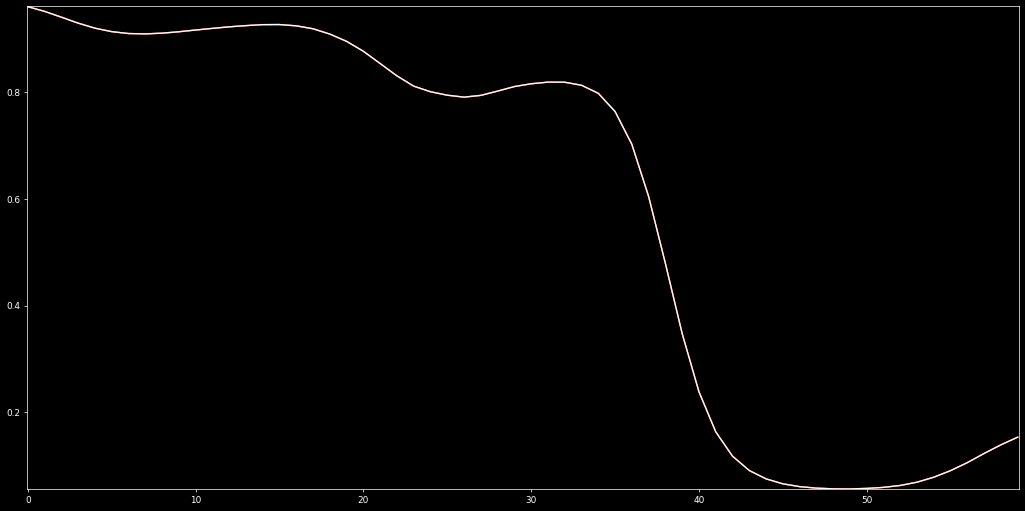

In [ ]:
model.reset_states()
plt.figure(figsize=(20,10))
plt.plot(model.predict(test_gen[0][0])[0,:])
plt.plot(model.predict(test_gen[0][0])[0,:],c='r')

model.reset_states()
# model.predict(t)
plt.plot(model.predict(test_gen[0][0])[0,:],c='w')

In [ ]:
# 결과확인
model.load_weights(FILE_MODEL)

model.reset_states()
val_pred = model.predict(val_gen)

model.reset_states()
test_pred = model.predict(test_gen)
 

val_y = np.concatenate([val_gen[i][1] for i in range(len(val_gen))])
test_y = np.concatenate([test_gen[i][1] for i in range(len(test_gen))])

val_y       = np.concatenate(val_y)
val_pred    = np.concatenate(val_pred)
test_y      = np.concatenate(test_y)
test_pred   = np.concatenate(test_pred)

plt.plot(val_pred, c='r')
plt.plot(val_y)
plt.show()

plt.plot(test_pred, c='r')
plt.plot(test_y)
plt.show()

print(f'{metrics.mean_squared_error(val_y, val_pred):.4f} {metrics.r2_score(val_y, val_pred):.4f}')
print(f'{metrics.mean_squared_error(test_y, test_pred):.4f} {metrics.r2_score(test_y, test_pred):.4f}')

KeyboardInterrupt: ignored

1760


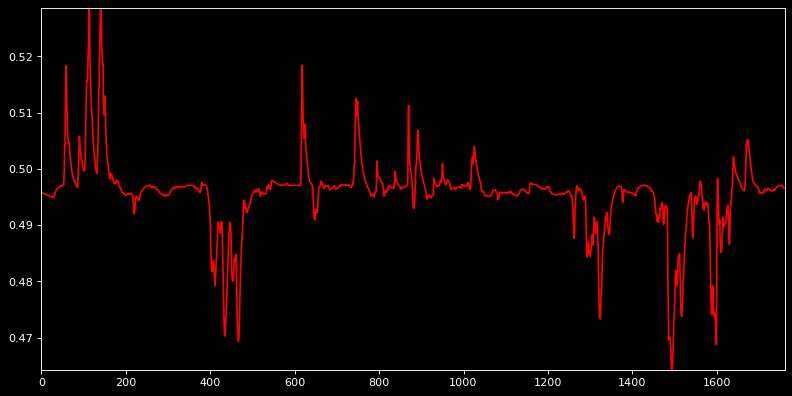

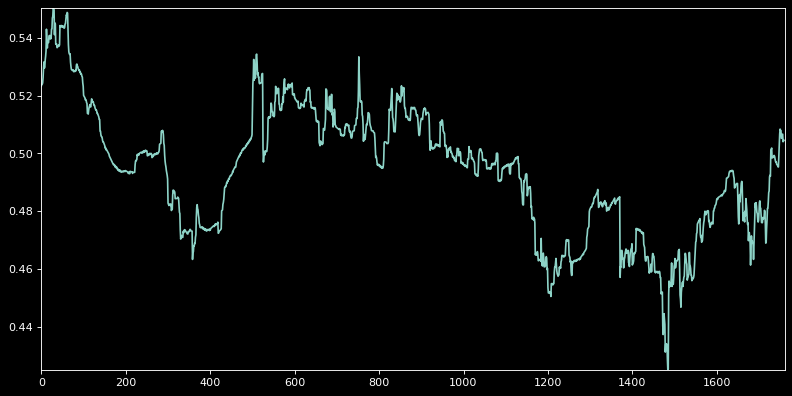

In [ ]:
model.load_weights(FILE_MODEL)

test_pred = []
test_y = []

test_data = df[-2000:]
test_gen = TimeseriesGenerator(data=test_data[xlist].values, targets=test_data[ylist].values, length=TIMESTEP, stride=stride, batch_size=batch_size, shuffle=False)

print(len(test_data)-stride*2)

for i in range(len(test_data)-stride*2):
    test_gen.start_index = stride + i
    test_gen.end_index = stride*2 + i
    test_y.append(test_gen[0][1][:,-1].item())
    test_pred.append(model.predict(test_gen)[-1,-1].item())

# print(f'{metrics.log_loss(test_y, test_pred):.4f} {metrics.accuracy_score(test_y, np.asarray(test_pred)>=0.5):.4f}')

plt.plot(test_pred, c='r')
plt.show()
plt.plot(test_y )

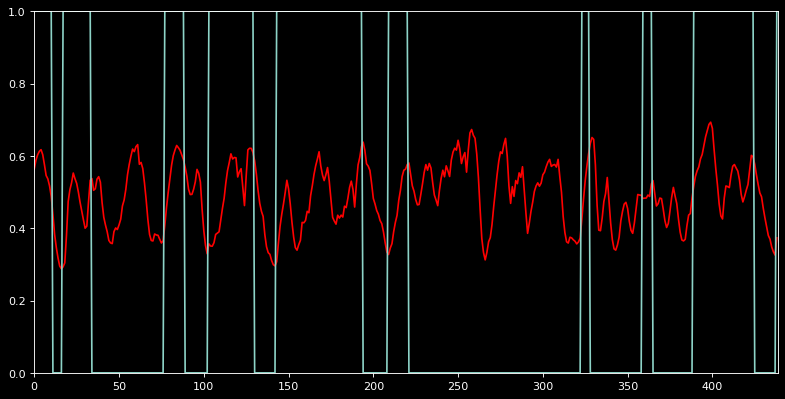

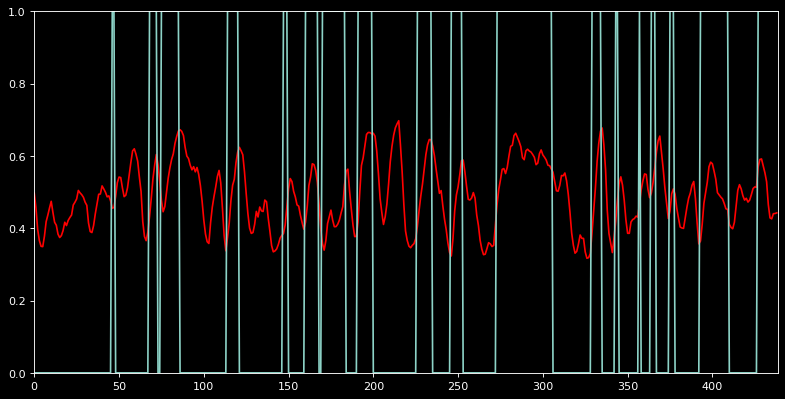

0.6783 0.5672
0.6525 0.6241


In [ ]:
model.load_weights(FILE_MODEL)
TIMESTEP = 60
stride= 1
batch_size = 1

# val
val_data = df[-1000:-500]
val_gen = TimeseriesGenerator(data=val_data[xlist].values, targets=val_data[ylist].values, length=TIMESTEP, stride=stride, batch_size=batch_size, shuffle=False)

# test
test_data = df[-500:]
test_gen = TimeseriesGenerator(data=test_data[xlist].values, targets=test_data[ylist].values, length=TIMESTEP, stride=stride, batch_size=batch_size, shuffle=False)


model.reset_states()
val_pred = model.predict(val_gen)

model.reset_states()
test_pred = model.predict(test_gen)
 
val_y = np.concatenate([val_gen[i][1] for i in range(len(val_gen))])
test_y = np.concatenate([test_gen[i][1] for i in range(len(test_gen))])

val_y       = val_y[:,-1]
val_pred    = val_pred[:,-1]
test_y      = test_y[:,-1]
test_pred   = test_pred[:,-1]

plt.plot(val_pred, c='r')
plt.plot(val_y)
plt.show()

plt.plot(test_pred, c='r')
plt.plot(test_y)
plt.show()

print(f'{metrics.log_loss(val_y, val_pred):.4f} {metrics.accuracy_score(val_y, val_pred>=0.5):.4f}')
print(f'{metrics.log_loss(test_y, test_pred):.4f} {metrics.accuracy_score(test_y, test_pred>=0.5):.4f}')

In [ ]:
test_data = df[-10000:]
test_gen = TimeseriesGenerator(data=test_data[xlist].values, targets=test_data[ylist].values, length=TIMESTEP, stride=120, batch_size=batch_size, shuffle=False)

preds=[]
y = []
for i in range(200):
    test_gen.start_index = 120+i
    test_gen.end_index = 2400+i
    model.reset_states()
    pred = model.predict(test_gen)[-1].item()
    preds.append(pred)
    y.append(test_gen[18][1][0,-1,0])



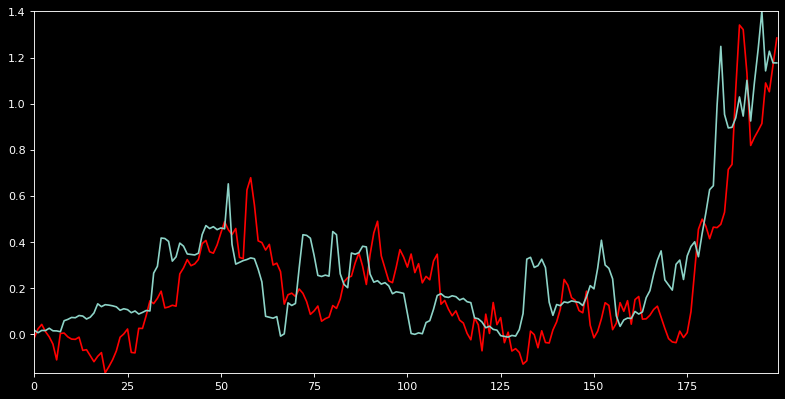

In [ ]:
plt.plot(preds,c='r')
plt.plot(y)

In [ ]:
model = create_model(x_num=50, ret_seq=False)
model.load_weights(FILE_MODEL)

In [ ]:
#@title 반복 학습하기
tf.get_logger().setLevel("ERROR")

TRAIN_LENGTH= 1000
VAL_LENGTH = 2000

# Train & Val Cross Learning
train_data  = df[:-TEST_LENGTH]
train_gen   = FixedTimeseriesGenerator(fixed_length=TRAIN_LENGTH, data=train_data[xlist].values, targets=train_data[ylist].values, shuffle=False, length=TIMESTEP, batch_size=1)
val_gen     = FixedTimeseriesGenerator(fixed_length=VAL_LENGTH, data=train_data[xlist].values, targets=train_data[ylist].values, shuffle=False, length=TIMESTEP, batch_size=1)

test_data = df[-TEST_LENGTH:]
test_gen = TimeseriesGenerator(data=test_data[xlist].values, targets=test_data[ylist].values, length=TIMESTEP, batch_size=1, shuffle=False)

cross_val_freq = 10
train_cross = CrossLearnCallback(train_gen, target=val_gen, patience=1, name='train', reset_weight=False)
val_cross   = CrossLearnCallback(val_gen, target=train_gen, patience=100, name='val', reset_weight=False)

rsc = ResetStatesCallback()
mcp = callbacks.ModelCheckpoint(FILE_CHECKPOINT, monitor='val_loss', save_best_only=True, verbose=1, save_weights_only=True, period=cross_val_freq)
# best = callbacks.ModelCheckpoint(FILE_MODEL, monitor='val_loss', save_best_only=True, verbose=1, save_weights_only=True, period=cross_val_freq)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min', min_lr=0.0000001, min_delta=0)
es = callbacks.EarlyStopping(monitor='val_loss', patience=12, verbose=1, restore_best_weights=True, min_delta=0) 
csvLogger = callbacks.CSVLogger(TEST_PATH+'train.log', separator='\t', append=True)

# model = create_model(lr=0.0001,  x_num=len(xlist), y_num=len(ylist))
# model.load_weights(FILE_MODEL)
hist = model.fit(train_gen, validation_data=val_gen, steps_per_epoch=len(train_gen), shuffle=False, validation_freq=cross_val_freq, epochs=6000, verbose=1, callbacks=[train_cross, val_cross, rsc, mcp, es, reduce_lr, csvLogger])

tf.get_logger().setLevel("INFO")

# 특성 검사

In [ ]:
test_length=1000

for x in range(len(xlist)):
    print(xlist[x])
    plt.figure(figsize=(40,10))
    for d in range(20):
        test = df[-test_length-d:-d].reset_index(drop=True)
        plt.plot(test[xlist[x]])
    plt.show()

In [ ]:
#@title 반복 검색
tf.get_logger().setLevel("ERROR")
from collections import Counter
# cnt = Counter()

test_data = signal_data[-50000:].reset_index(drop=True)
xlist = 'dema_2 closema_2 rsi_9 rsi_2 closema_12 willr_3 high_15 dema_3 kama_16 stochf_2 rsi_7 stochf_4 stochf_13 stochf_11 stochf_3 high_29 low_38 stddev_28 rsi_292 stochf_6 rsi_5 stddev_27 high_10'.split(' ')
batch_size = 1
TIMESTEP = 30

for index in range(100):
    
    # xlist 변조
    olist = xlist
    xlist = perm_xlist(xlist, 1)

    # 피쳐 생성
    df, xlist, ylist = create_features(test_data, xlist, True)

    # 혹시 모를 인디케이터용 여분 추가 제거
    df = df[2000:-2000]
    # print('================================')
    df = df.replace([np.inf, -np.inf], 0)

    # 스케일링
    xscaler = preprocessing.RobustScaler(quantile_range=(1,99))
    df[xlist] = xscaler.fit_transform(df[xlist])
    df[xlist] = np.clip(df[xlist], -1, 1)

    # Train & Val Cross Learning
    train_data = df[:-10000]
    train_gen = TimeseriesGenerator(data=train_data[xlist].values, targets=train_data[ylist].values, length=TIMESTEP, stride=TIMESTEP, batch_size=batch_size, shuffle=False)

    # val
    val_data = df[-10000:]
    val_gen = TimeseriesGenerator(data=val_data[xlist].values, targets=val_data[ylist].values, length=TIMESTEP, stride=TIMESTEP, batch_size=batch_size, shuffle=False)
    print('================================')
    print('데이터 Legnth', len(train_data), len(val_data))
    print('시퀀스 Length', len(train_gen), len(val_gen))
    # print('================================')

    # 학습
    rsc = ResetStatesCallback()
    best = callbacks.ModelCheckpoint(FILE_MODEL, monitor='val_loss', save_best_only=True, verbose=1, save_weights_only=True)
    es = callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True, min_delta=0) 

    model = create_model(lr=0.0001, x_num=len(xlist), y_num=len(ylist), batch_size=batch_size, timestep=TIMESTEP)
    hist = model.fit(train_gen, validation_data=val_gen, steps_per_epoch=len(train_gen), shuffle=False, epochs=7, verbose=1, callbacks=[rsc, best, es])
    model.load_weights(FILE_MODEL)
    model.reset_states()
    
    # 중요도 측정
    result = var_importance(model, train_gen, xlist, batch_size)

    xlist = result.nlargest(20).index.to_list() + olist[:10]
    xlist = list(dict.fromkeys(xlist))

    for i in xlist:
        cnt[i] += 1
    
    clear_output()    
    print(index, " ".join(xlist)+'\n')

    with open(FILE_FEATURE_LOG, 'a', encoding='utf-8') as file:
        file.write('{} {}\n'.format(index, hist.history['loss'][-1]))
        file.write('xlist : ' + ' '.join(xlist)+'\n')
        file.write('Common : ' + " ".join('{}:{}'.format(k, v) for k, v in cnt.most_common())+'\n')
        # file.write(" ".join('{}:{}'.format(k, v) for k, v in cnt_loss.most_common()[::-1])+'\n')
        

tf.get_logger().setLevel("INFO")

23 pvt_125 cci_213 willr_124 atr_19 dema_115 macdf_100 stochf_76 mstoch_86 mfi_245 macdf_231 macdf_96 low_226 pvt_181 kama_218 wma_110 close_262 macdf_221 atr_10 cci_209 mfi_238 dema_114 willr_123 cci_202 stddev_57 willr_118 cci_206 dema_112

========== Indicators ==========
pvt_125 pvt_124 cci_213 cci_216 willr_124 willr_116 atr_19 atr_9 dema_115 dema_111 macdf_100 macdf_105 stochf_76 stochf_68 mstoch_86 mstoch_78 mfi_245 mfi_246 macdf_231 macdf_226 macdf_96 macdf_90 low_226 low_233 pvt_181 pvt_184 kama_218 kama_213 wma_110 wma_101 close_262 close_261 macdf_221 macdf_215 atr_10 atr_4 cci_209 cci_208 mfi_238 mfi_237 dema_114 dema_122 willr_123 cci_202 cci_194 stddev_57 stddev_49 willr_118 willr_117 cci_206 cci_204 dema_112 dema_120 adosc_154 adx_77 close_119 dx_105 mfi_123 mom_64 mstoch_144 stochf_188 trix_57 tsf_282 rsi_226 willr_286 atr_151 cci_185 closema_196 dema_34 high_98 kama_142 low_214 macd_57 macdf_211 pvt_17 qstick_245 sma_145 stddev_42 wma_266 
============== X ============

yclose    5
dtype: int64

데이터 Legnth 35367 10000
시퀀스 Length 1177 332
Train for 1177 steps, validate for 332 steps
Epoch 1/7
1172/1177 [============================>.] - ETA: 0s - loss: 0.1781 - acc: 0.5095
Epoch 00001: val_loss improved from inf to 0.17152, saving model to drive/My Drive/Projects/1m v2/다시 테스트/train.h5
1177/1177 [==============================] - 17s 14ms/step - loss: 0.1781 - acc: 0.5096 - val_loss: 0.1715 - val_acc: 0.5596
Epoch 2/7
1174/1177 [============================>.] - ETA: 0s - loss: 0.1750 - acc: 0.5220
Epoch 00002: val_loss improved from 0.17152 to 0.17125, saving model to drive/My Drive/Projects/1m v2/다시 테스트/train.h5
1177/1177 [==============================] - 14s 12ms/step - loss: 0.1751 - acc: 0.5219 - val_loss: 0.1712 - val_acc: 0.5659
Epoch 3/7
1174/1177 [============================>.] - ETA: 0s - loss: 0.1747 - acc: 0.5198
Epoch 00003: val_loss did not improve from 0.17125
1177/1177 [==============================] - 13s 11ms/step - loss: 0.1747 - acc: 0.5199 - val_loss: 0.1

KeyboardInterrupt: ignored

In [ ]:
from scipy.spatial.distance import cosine

FEATURE_LIST =  'adosc adx close dx mfi mom mstoch skew stochf trix tsf rsi willr atr cci closema cmf dema high kama low macd macdf pvt qstick sma stddev volume wma zscore'.split(' ')
flist = gen_xlist(2,480,1)
data = signal_data[-20000:]

for i in range(0, len(flist)-10, 10):
    xlist = flist[i:i+10]
    df, xlist, ylist = create_features(signal_data[-20000:], xlist, False)
    df  = df[500:-500]

    # 스케일링
    xscaler = preprocessing.RobustScaler(quantile_range=(1,99))
    yscaler = preprocessing.RobustScaler(quantile_range=(1,99))

    # x
    df[xlist] = xscaler.fit_transform(df[xlist])
    df[xlist] = np.clip(df[xlist], -1, 1)

    df.yclose = yscaler.fit_transform(df[['yclose']])
    df.yclose = np.clip(df.yclose, -1, 1)

   
    for x in xlist:
        with open(TEST_PATH+'r2-binary.log', 'a', encoding='utf-8') as file:
            file.write(x + ' ' + str(metrics.r2_score(df[x],df[ylist]))+'\n') 
        with open(TEST_PATH+'cos-binary.log', 'a', encoding='utf-8') as file:
            file.write(x + ' ' + str(1-cosine(df[x],df[ylist]))+'\n') 

In [ ]:
#@title 구간 특정 Feature 테스트
from collections import Counter

counter = Counter()
FEATURE_LIST =  'adosc adx close dx mfi mom mstoch skew stochf trix tsf rsi willr atr cci closema cmf dema high kama low macd macdf pvt qstick sma stddev volume wma zscore'.split(' ')
flist = gen_xlist(2,240,2)
print('전체 Feature 숫자',len(flist))
data = signal_data[-20000:]

def create_test_model(lr=0.00004, x_num = 1, y_num = 1, predict=False):
    K.clear_session()
    gc.collect()

    inputs = layers.Input(batch_shape=(BATCH_SIZE, TIMESTEP, x_num))

    x1 = layers.GRU(100, stateful=True, return_sequences=False)(inputs)
    output = layers.Dense(y_num, activation='sigmoid', name='out')(x1)
    # Model
    model = Model(inputs=inputs, outputs = output)
    model.compile(optimizer=optimizers.Nadam(learning_rate=lr), loss=n_loss(0.4), metrics=['acc', losses.binary_crossentropy]) # [lmse(3),lmse(2)]
    return model

for index in range(300):
    print(index)
    xlist = random.sample(flist, 50)
    xlist = sorted(xlist)

    df, xlist, ylist = create_features(data, xlist, True)
    df = df[500:-500]

    # 스케일링
    xscaler = preprocessing.RobustScaler(quantile_range=(1,99))
    
    # x
    df[xlist] = preprocessing.robust_scale(df[xlist], quantile_range=(1,99))
    df[xlist] = np.clip(df[xlist], -1.1, 1.1)
    df[xlist] = preprocessing.minmax_scale(df[xlist])

    # train
    train_gen = FixedTimeseriesGenerator(fixed_length=1000, data=df[xlist].values, targets=df[ylist].values, length=TIMESTEP, batch_size=1, shuffle=False)
    
    # val
    val_gen = FixedTimeseriesGenerator(fixed_length=1000, data=df[xlist].values, targets=df[ylist].values, length=TIMESTEP, batch_size=1, shuffle=False)

    train_cross = CrossLearnCallback(train_gen, val_gen, 1000000, 'train')
    val_cross = CrossLearnCallback(val_gen, train_gen, 1000000, 'val')
    rsc = ResetStatesCallback()
    es = callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=5, verbose=1, min_delta=0) 

    model = create_test_model(lr=0.00004, x_num=len(xlist), y_num=len(ylist))
    hist = model.fit(train_gen, validation_data=val_gen, steps_per_epoch=len(train_gen), epochs=10, verbose=1, callbacks=[rsc, es, train_cross, val_cross])

    counter[' '.join(xlist)] = es.best
    
    clear_output()
    print(f"{es.best:0.5f} : {' '.join(xlist)}")

    with open(FILE_FEATURE_LOG, 'w', encoding='utf-8') as file:
        file.write("\n".join('{:.5f} {}'.format(v, k) for k, v in counter.most_common()[::-1]))
    


In [ ]:
#@title 피쳐 중요도 테스트 
TIMESTEP = 60
stride = 60
t = 10
batch_size = 1

train_data = df[:-6400]
train_gen = TimeseriesGenerator(data=train_data[xlist].values, targets=train_data[ylist].values, length=TIMESTEP, stride=stride, batch_size=batch_size, shuffle=False, reverse=False)



model = create_model(x_num=len(xlist))
model.load_weights(FILE_MODEL)

# 중요도 측정
result = var_importance(model, train_gen, xlist, 1) #  with tf.device('/cpu:0'):
print_pd(result.sort_values(ascending=False))

closema_66    0.03701
bsma_60       0.03557
close_2       0.03446
dema_2        0.03407
closema_30    0.03390
high_10       0.03269
bclosema_15   0.03246
wma_25        0.03207
kama_4        0.03146
bwma_8        0.03135
closema_4     0.03129
closema_79    0.03090
tsf_20        0.03072
brsi_21       0.03071
closema_84    0.03066
pvt_60        0.03057
bwma_5        0.03042
bmacdf_40     0.03037
rsi_12        0.03031
bdema_120     0.03024
bdema_6       0.03016
dema_11       0.03008
dema_14       0.02989
tsf_120       0.02981
rsi_19        0.02979
rsi_20        0.02976
tsf_55        0.02956
tsf_113       0.02951
brsi_27       0.02936
bdema_16      0.02924
low_10        0.02916
pvt_27        0.02903
bsma_20       0.02900
closema_25    0.02893
bdema_21      0.02870
bdema_91      0.02856
bsma_35       0.02837
willr_42      0.02783
bdema_13      0.02773
bdema_2       0.02768
dtype: float64

In [ ]:
#@title 코사인 유사도
from scipy.spatial.distance import cosine
xlist, xscaler = joblib.load(FILE_SCALER)

df, xlist, ylist = create_features(signal_data, xlist, False)

data= df[10000:-10000]
result = []
for x in xlist:
    result.append(1-cosine(data[x], data.yclose))

result= pd.Series(result, index=xlist)
result.sort_values(ascending=False)

In [ ]:
#@title Counter 합치기
from collections import Counter

common = 'blow_68:9 tsf_118:8 closema_82:8 bclosema_117:8 rsi_33:7 bmacdf_49:7 bclosema_111:7 blow_63:7 tsf_163:7 bdema_11:6 tsf_124:6 low_154:6 wma_58:6 btsf_163:6 bcci_80:6 macdf_46:6 closema_71:6 closema_65:6 low_9:6 bwma_106:6 tsf_120:6 dema_41:6 trix_153:6 tsf_114:5 bdema_8:5 bdema_22:5 tsf_121:5 bclosema_207:5 bwma_82:5 closema_78:5 closema_91:5 tsf_171:5 close_274:5 tsf_175:4 bhigh_224:4 tsf_178:4 bkama_180:4 sma_255:4 bwma_117:4 bwma_146:4 tsf_104:4 bnatr_199:4 bmacdf_40:4 rsi_274:4 wma_56:4 bmacdf_83:4 mom_38:4 bwma_105:4 bmacdf_43:4 tsf_251:4 high_237:4 bwma_57:4 macdf_166:4 wma_266:4 tsf_110:4 closema_80:4 mfi_166:4 tsf_123:4 bhigh_26:4 bdema_178:4 bcci_221:4 closema_87:4 brsi_49:4 zscore_149:4 tsf_131:4 bclose_231:4 bkama_27:4 close_265:4 tsf_115:4 low_135:4 bmacdf_7:4 bmom_233:3 btrix_22:3 bdema_89:3 tsf_130:3 bwma_64:3 rsi_31:3 bdema_13:3 btsf_166:3 bmacdf_47:3 bmacdf_41:3 macdf_58:3 btsf_157:3 blow_64:3 wma_139:3 close_281:3 bwma_51:3 zscore_60:3 closema_54:3 low_11:3 bdema_183:3 wma_232:3 dema_42:3 btsf_162:3 bclosema_124:3 dema_43:3 btsf_235:3 high_223:3 btsf_116:3 dema_50:3 trix_119:3 bclose_66:3 rsi_52:3 mfi_78:3 high_100:3 wma_59:3 zscore_113:3 wma_184:2 mom_9:2 bcci_178:2 bwma_121:2 mfi_21:2 bdema_97:2 bmacdf_75:2 wma_135:2 bclose_255:2 bsma_99:2 bcci_239:2 dema_132:2 rsi_217:2 bwma_68:2 bclose_65:2 bclosema_70:2 high_20:2 rsi_73:2 bwma_112:2 bwma_183:2 qstick_79:2 btsf_174:2 macd_22:2 kama_128:2 bclose_59:2 mom_6:2 brsi_176:2 kama_28:2 qstick_69:2 bwma_107:2 macd_24:2 kama_265:2 bdema_9:2 bdema_185:2 btrix_288:2 bhigh_147:2 rsi_133:2 sma_190:2 zscore_63:2 dema_32:2 bdema_14:2 macdf_50:2 bhigh_167:2 bmacdf_50:2 batr_157:2 bclosema_27:2 closema_16:2 dema_16:2 dema_39:2 bmacdf_16:2 natr_42:2 trix_20:2 bclosema_19:2 dema_18:2 rsi_275:2 bdema_129:2 bclosema_13:2 brsi_293:2 close_131:2 kama_238:2 mfi_22:2 bwma_139:2 btrix_155:2 closema_70:2 bsma_2:2 stddev_283:2 blow_53:2 macd_223:2 macdf_53:2 mfi_15:2 bclosema_3:2 mfi_95:2 macd_221:2 bmacd_40:2 macdf_41:2 bwma_53:2 blow_55:2 mom_36:2 closema_58:2 bsma_105:2 btsf_22:2 bclosema_103:2 macd_7:2 bwma_49:2 bclosema_97:2 high_198:2 tsf_221:2 bmacdf_137:2 close_157:2 closema_57:2 closema_64:2 macd_194:2 zscore_167:2 brsi_101:2 btsf_169:2 closema_61:2 wma_273:2 bhigh_152:2 qstick_138:2 dema_65:2 low_2:2 sma_101:2 btsf_283:2 bmacdf_11:2 bkama_221:2 bzscore_188:2 close_229:2 bmacdf_18:2 stddev_268:2 mom_172:2 high_283:2 mom_249:2 bhigh_33:2 kama_118:2 mfi_156:2 bdema_242:2 trix_286:2 kama_115:2 mom_255:2 bmacd_295:2 blow_74:2 btsf_165:2 stddev_199:2 bzscore_47:2 kama_125:2 bdema_171:2 rsi_252:2 close_6:2 macd_95:2 bdema_173:2 bcci_214:2 bwma_87:2 bdema_184:2 bdema_93:2 rsi_259:2 stddev_207:2 trix_48:2 wma_158:2 closema_77:2 high_190:2 low_16:2 mom_178:2 dema_35:2 bhigh_121:2 tsf_127:2 kama_216:2 bcci_70:2 cci_15:2 tsf_129:2 closema_83:2 blow_205:2 bsma_162:2 bclosema_109:2 bhigh_11:2 bmacd_211:2 tsf_128:2 rsi_234:2 qstick_250:2 tsf_190:2 high_21:2 blow_69:2 qstick_113:2 bmacd_214:2 cci_8:2 macd_77:2 rsi_216:2 rsi_10:2 blow_70:2 trix_151:2 macd_75:2 kurtosis_251:2 mfi_62:2 tsf_197:2 macd_72:2 rsi_17:2 sma_178:2 blow_72:2 bkama_24:2 tsf_170:2 bsma_66:2 blow_75:2 blow_137:2 btsf_43:2 macdf_274:2 bhigh_69:2 mfi_117:2 zscore_91:2 btsf_44:2 closema_113:2 close_262:2 tsf_169:2 btrix_61:2 bwma_203:2 bdema_293:2 btsf_227:2 zscore_154:2 close_268:2 bhigh_65:2 wma_211:2 bwma_189:2 tsf_162:2 bclosema_151:2 btrix_42:2 bhigh_63:2 wma_295:2 mfi_70:2 bmacdf_277:2 dema_146:2 tsf_166:2 dema_144:2 bmacdf_273:2 mfi_144:2 btrix_50:2 low_130:2 low_42:2 bhigh_60:2 bmacdf_3:2 high_96:2 kurtosis_295:2 wma_80:2 high_87:1 macdf_74:1 btrix_40:1 mom_71:1 dema_145:1 kama_93:1'.split(' ')
cnt = Counter()
for x in common:
    a, b, = x.split(':')
    cnt[a] += int(b)

# ' '.join([key for key, value in cnt.most_common(114)])

In [ ]:
#@title 반복 검색
from collections import Counter

cnt = Counter()
TIMESTEP = 60
stride = 60
t = 60
batch_size = 1

counter = Counter()
FEATURE_LIST =  'bwma tsf btsf dema bdema wma closema close mfi qstick high bclose mom rsi bhigh low blow macdf kama bmom bclosema bmacdf trix macd zscore bsma bkama btrix sma bmacd bcci brsi cci bzscore'.split(' ')
xlist = 'high_87 zscore_113 tsf_124 macdf_74 btrix_40 wma_59 bmacdf_3 mom_71 dema_145 kama_93 low_130 low_42 bhigh_60 high_96 tsf_118 tsf_171 kurtosis_295 wma_80 close_274'.split(' ')
test_data = signal_data[-25000:]

def create_test_model(lr=0.00004, batch_size = BATCH_SIZE, timestep = TIMESTEP, x_num = 1, y_num = 1):
    K.clear_session()
    gc.collect()

    #### Inputs
    inputs = layers.Input(shape=(timestep, x_num), batch_size=batch_size)

    x = layers.Conv1D(80, 10, activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = layers.Conv1D(x_num, 10, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = layers.Add()([x, inputs])
    x = layers.GaussianDropout(0.4)(x)

    x = layers.GRU(160, stateful=True, return_sequences=True, dropout=0.2,)(x)
    x = layers.GRU(200, stateful=True, return_sequences=True, dropout=0.2,)(x)
    x = layers.GRU(160, stateful=True, return_sequences=True, dropout=0.2,)(x)
    x = layers.GaussianDropout(0.4)(x)

    #### Outputs
    output = layers.TimeDistributed(layers.Dense(2, activation='linear', kernel_regularizer=l2(0.001)), name='low')(x)
    model = Model(inputs=inputs, outputs = output)
    model.compile(optimizer=optimizers.Nadam(learning_rate=lr), loss='mse', metrics=[i_loss], sample_weight_mode='temporal')
    return model

class RollingCallback(callbacks.Callback):
    def __init__(self, generator=None):
        super(RollingCallback, self).__init__()
        self.generator = generator
        self.length = generator.length      # 타임 스텝 길이
        self.start_index = generator.start_index
        self.end_index = generator.end_index-60

        generator.end_index = generator.end_index-60
    
    def on_epoch_begin(self, epoch, logs):
        seed =epoch%random.randint(1, self.length)
        self.generator.start_index = self.start_index+seed
        self.generator.end_index = self.end_index+seed


for index in range(300):
    
    # xlist 변조
    olist = xlist
    xlist = perm_xlist(xlist, 1)

    # 피쳐 생성
    df, xlist, ylist = create_features(test_data, xlist, True)

    # 혹시 모를 인디케이터용 여분 추가 제거
    df = df[1000:-1000]
    df = df.replace([np.inf, -np.inf], 0)

    # x
    df[xlist] = xscaler.fit_transform(df[xlist])
    df[xlist] = np.clip(df[xlist], -1, 1)

    #y
    yscaler.fit(np.expand_dims(df[ylist].values.flatten(),1))
    df[ylist] = yscaler.transform(df[ylist])
    df[ylist] = np.clip(df[ylist], -1, 1)

    # train
    train_data = df[-21000:-4000]
    train_gen = TimeseriesGenerator(data=train_data[xlist].values, targets=train_data[ylist].values, length=TIMESTEP, stride=stride, batch_size=batch_size, shuffle=False, reverse=False)

    # val
    val_data = df[-4000:]
    val_gen = TimeseriesGenerator(data=val_data[xlist].values, targets=val_data[ylist].values, length=TIMESTEP, stride=stride, batch_size=batch_size, shuffle=False, reverse=False)

    print('데이터 Legnth', len(train_data), len(val_data))
    print('시퀀스 Length', len(train_gen), len(val_gen))

    rsc = ResetStatesCallback()
    es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=0) 
    train_roll = RollingCallback(train_gen)
    best = callbacks.ModelCheckpoint(FILE_MODEL, monitor='loss', save_best_only=True, verbose=1, save_weights_only=True)

    model = create_test_model(lr=0.00004, x_num=len(xlist), y_num=len(ylist))
    hist = model.fit(train_gen, validation_data=val_gen, steps_per_epoch=len(train_gen), epochs=15, verbose=1, callbacks=[rsc, es, train_roll, best])
    model.load_weights(FILE_MODEL)
    model.reset_states()

    # 중요도 측정
    result = var_importance(model, train_gen, xlist, batch_size=1)
    xlist = result.nlargest(20).index.to_list() + olist[:20]
    xlist = list(dict.fromkeys(xlist))

    for i in xlist:
        cnt[i] += 1
    
    clear_output()    
    print(index, " ".join(xlist)+'\n')

    with open(FILE_FEATURE_LOG, 'a', encoding='utf-8') as file:
        file.write('{} {}\n'.format(index, hist.history['loss'][-1]))
        file.write('xlist : ' + ' '.join(xlist)+'\n')
        file.write('Common : ' + " ".join('{}:{}'.format(k, v) for k, v in cnt.most_common())+'\n')
        # file.write(" ".join('{}:{}'.format(k, v) for k, v in cnt_loss.most_common()[::-1])+'\n')
        

tf.get_logger().setLevel("INFO")

299 closema_150 dema_181 bwma_13 bhigh_57 bhigh_48 low_99 bclosema_25 tsf_138 bhigh_63 bdema_24 bmom_245 bwma_11 high_54 low_103 tsf_238 low_305 bmom_243 bdema_15 bclosema_22 mfi_231 bwma_8 macd_229 closema_207 qstick_257 tsf_129 blow_65 blow_176 mfi_271 bcci_87 qstick_207 bzscore_243 brsi_35 bdema_16 brsi_30 bmacd_252 bhigh_8



In [ ]:
#@title 적합성 테스트

xlist = 'cci_5 rsi_20 rsi_42 atr_40 atr_44 zscore_39 trix_27 trix_6 macdf_3 tsf_48 rsi_46'.split(' ')
train_data, xlist, ylist = create_features(signal_data, xlist, log=True)
train_data= train_data[1000:-1000]

# # 스케일링
xscaler = preprocessing.RobustScaler(quantile_range=(2,98))
yscaler = preprocessing.RobustScaler(quantile_range=(2,98))

# x
train_data[xlist] = xscaler.fit_transform(train_data[xlist])
train_data[xlist] = np.clip(train_data[xlist], -1, 1)

#y
yscaler.fit(np.expand_dims(train_data[ylist].values.flatten(),1))
train_data[ylist] = yscaler.transform(train_data[ylist])
train_data[ylist] = np.clip(train_data[ylist], -1, 1)


# 데이터 셋 생성
train_gen = FixedTimeseriesGenerator(data=train_data[xlist].values, targets=train_data[ylist].values, length=TIMESTEP, batch_size=1, fixed_length=5000)
val_gen = FixedTimeseriesGenerator(data=train_data[xlist].values, targets=train_data[ylist].values, length=TIMESTEP, batch_size=1, fixed_length=1000)

csvLogger = callbacks.CSVLogger(TEST_PATH+'train.log', separator='\t', append=False)
rsc = ResetStatesCallback()
mcp = callbacks.ModelCheckpoint(FILE_MODEL, monitor='val_acc', save_best_only=True, verbose=1, save_weights_only=True,)

model = create_model(x_num=len(xlist), y_num=len(ylist))
hist = model.fit(train_gen, validation_data=val_gen,steps_per_epoch=len(train_gen), epochs=10, verbose=1, shuffle=False, callbacks=[rsc,mcp, train_cross, val_cross, csvLogger])
model.load_weights(FILE_MODEL)

# 중요도 측정
result = var_importance(model, train_gen, xlist) #  with tf.device('/cpu:0'):
print_pd(result.sort_values(ascending=False))

========== Indicators ==========
cci_5 rsi_20 rsi_42 atr_40 atr_44 zscore_39 trix_27 trix_6 macdf_3 tsf_48 rsi_46 
============== X ===============
============== Y ===============
yhigh ylow
============ Result ============
Total Features: 11
Input Length: 299615
Dropped Length: 79
Result Length: 299536
=========== Na 체크 ============


yhigh    10
ylow     10
dtype: int64

NameError: ignored

In [ ]:

# 중요도 측정
result = var_importance(model, train_gen, xlist) #  with tf.device('/cpu:0'):
print_pd(result.sort_values(ascending=False))

closema_3     0.13198
qstick_2      0.10220
adosc_16      0.07085
macdf_2       0.06835
mfi_44        0.06771
willr_49      0.06736
macd_26       0.06564
kurtosis_20   0.06227
rsi_6         0.06172
mom_48        0.06096
stochf_55     0.05789
dema_67       0.05720
kama_38       0.05236
cci_5         0.04892
zscore_34     0.04885
mom_17        0.04850
macd_32       0.04682
willr_33      0.04213
mfi_57        0.04136
cci_24        0.04038
cci_31        0.03991
willr_45      0.03951
cmf_6         0.03866
kurtosis_24   0.03722
cmf_46        0.03692
mfi_6         0.03615
dx_3          0.03571
macdf_40      0.03439
macd_33       0.03375
macdf_57      0.03292
tsf_52        0.03161
cci_19        0.03155
adx_30        0.03152
tsf_44        0.03141
adosc_23      0.02718
tsf_16        0.02633
kurtosis_12   0.02203
kama_35       0.02184
volume_2      0.01391
kurtosis_4    0.01033
dtype: float64

# mutual_info_classif


In [ ]:
from sklearn.feature_selection import mutual_info_classif
from collections import Counter

def randrange(total_length, step):
    return random.randrange(0, total_length-total_length%step-step, step)

xlist = gen_xlist(2,240,10)
data = signal_data[100000:]
cnt = Counter()

for index in range(300):
    # xlist 변조
    xlist = perm_xlist(xlist, 2)

    # 피쳐 생성   

    start = randrange(len(data),10000)
 
    df, xlist, ylist = create_features(data[start:start+10000], xlist, True)

    # 스케일링
    xscaler = preprocessing.RobustScaler(quantile_range=(2,98))

    # x
    df[xlist] = xscaler.fit_transform(df[xlist])
    df[xlist] = np.clip(df[xlist], -1, 1)
    df[xlist] = preprocessing.minmax_scale(df[xlist])


    result = mutual_info_classif(df[xlist], df[ylist].astype(bool).values.ravel())
    result = pd.Series(result, index=xlist)
    xlist = result.nlargest(20).index.to_list()

    for i in xlist:
        cnt[i] += 1

    print(" ".join(xlist)+'\n')

    with open(FILE_FEATURE_LOG, 'a', encoding='utf-8') as file:
        file.write('{} {}\n'.format(index, hist.history['val_loss'][-1]))
        file.write('xlist : ' + ' '.join(xlist)+'\n')
        file.write('Common : ' + " ".join('{}:{}'.format(k, v) for k, v in cnt.most_common())+'\n')



# 온라인 테스트

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES']='-1'

model = create_model(lr=0.000001, x_num=40, y_num=3, timestep=60)
model.load_weights(FILE_MODEL)
xlist, xscaler, yscaler = joblib.load(FILE_SCALER)
from matplotlib.ticker import MultipleLocator

last_predict = ''
last = np.zeros(40)
REFRESH_TIMER = 30
partial = False

red = 'tab:red'
green = 'tab:green'
cyan = '#00bfbf'

def create_dataset(df, timestep = 1, x_list = None, y_list = None):
    # df = data.copy()
    dataX, dataY = [], []

    # 타임스탭 배열 만들기
    for i in range(1, int(len(df)/timestep)+1):
        dataX.append(df[x_list].values[(i-1)*timestep:i*timestep])
        dataY.append(df[y_list].values[(i-1)*timestep:i*timestep])
    return np.asarray(dataX), np.asarray(dataY)

class ResetStatesCallback(callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

rsc = ResetStatesCallback()

0.44442 * 10145 / 32 * 100

def myround(x, base=5):
    return int(base * round(x/base))

from mplfinance.original_flavor import candlestick2_ohlc


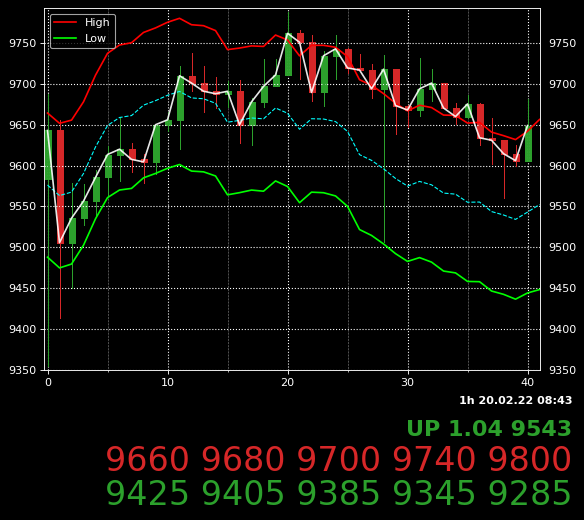

NameError: ignored

In [ ]:
while True:
    
    # 데이터 불러오기
    if time() % 3600 < 30:
        notify()
        partial = False

    else:
        partial = True

    # 데이터 불러오기
    signal = get_datas(count=500, partial= partial, period=PERIOD)


    # 피쳐 생성
    test_df, xlist, ylist = create_features(signal, xlist, log= False, test=True)
    test_df[xlist] = xscaler.transform(test_df[xlist])
    test_df[xlist] = np.clip(test_df[xlist], -1, 1)
    
    # test_df[ylist] = yscaler.transform(test_df[ylist])
    # test_df[ylist] = np.clip(test_df[ylist], -1, 1)

    # 데이터셋 생성
    test_x, test_y = create_dataset(test_df[-TIMESTEP*2:], TIMESTEP, xlist, ylist) 
    model.reset_states()

    # 예측하기    
    model.predict(test_x[-2:-1], batch_size=1)
    preds = model.predict(test_x[-1:], batch_size=1)

    pred_df = test_df[-TIMESTEP:]
    p = preds.copy()
    preds = yscaler.inverse_transform(preds[0]) * pred_df.ybase[:,None]

    ###### 차트 그리기
    # 가격
    fig, ax = plt.subplots(figsize=(8,6))
    draw = 41
    
    ax.plot(preds[-draw-1:, 0], c='red', label='High', linewidth=1.5,)
    ax.plot(preds[-draw-1:, 1], c='lime', label='Low', linewidth=1.5,)
    ax.plot(preds[-draw-1:,:2].mean(axis=1), c='cyan', linestyle='--', linewidth=1, label=None)
    # ax.plot(preds[-draw:,2], c='cyan', linestyle='--', linewidth=1, label='Trend')

    # 캔들스틱
    candlestick2_ohlc(ax, pred_df.open.values[-draw:], pred_df.high.values[-draw:], pred_df.low.values[-draw:], pred_df.close.values[-draw:], colorup=green, colordown=red, width=0.5, alpha=1)
    
    # ax.plot(pred_df.high.values[-draw:], c='darkred', linewidth=1,)
    # ax.plot(pred_df.low.values[-draw:], c='darkgreen', linewidth=1,)
    ax.plot(pred_df.close.values[-draw:], c='w', alpha=0.9)


    # ax.scatter(draw-20, preds[-20,2])
    # ax.scatter(draw-10, preds[-10,2])
    
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.grid(True,'minor', linestyle=':', linewidth=0.5)
    ax.xaxis.grid(True,'major', linestyle=':', linewidth=2)
    ax.grid(linestyle=':', linewidth=1)
    
    ax.legend(loc='upper left')
    ax.tick_params(labelright=True)

    # 정보 출력
    last_close = pred_df.close.values[-1]   # 현재 가격

    pred_high =  preds[-2,0] # 고가
    pred_low =   preds[-2,1] # 저가
    pred_center = preds[-2,:].mean() # 중간

    pred_trend = np.diff(preds[-3:,:].mean(axis=1)).sum() > 0
    # pred_trend = last_close < pred_center
    ratio = (last_close -  preds[-2,1])/(preds[-2,0] - preds[-2,1] )  # 현재 가격의 위치 1 : 최고점 0 최저점
    inter = (pred_high - pred_low) * 0.1



    # 시간
    now = datetime.now().strftime("%y.%m.%d %H:%M")
    plt.figtext(0.95, 0.05, PERIOD + ' ' + now, ha='right', va='bottom', weight='extra bold')


    
    if ratio > 0.5:
        ratio_color = 'tab:green'
    else:
        ratio_color = 'tab:red'

    if pred_trend: 
        trend_string = 'UP'
        trend_color= green
        
    else : 
        trend_string = 'DN'
        trend_color= red


    plt.figtext(0.95, -0.02,  f'{trend_string} {ratio:.2f} {round_t(pred_center)}', ha='right', va='bottom', weight='extra bold', color = trend_color, fontsize=20)
    plt.figtext(0.95, -0.1, f'{myround( pred_high + inter)} {myround( pred_high + inter*2)} {myround( pred_high + inter*3)} {myround( pred_high + inter*5)} {myround( pred_high + inter*8)}', ha='right', va='bottom', fontsize=30, color=red)
    plt.figtext(0.95, -0.17, f'{myround( pred_low - inter)} {myround( pred_low - inter*2)} {myround( pred_low - inter*3)} {myround( pred_low - inter*5)} {myround( pred_low - inter*8)}', ha='right', va='bottom', fontsize=30, color=green)
    ax.set_ylim(min(pred_df[-draw:].low.min(),preds[-draw:,1].min())-5, max(pred_df[-draw:].high.max(),preds[-draw:,0].max())+5)
    # ax.vlines(draw-6, min(pred_df[-draw:].low.min(),preds[-draw:,1].min())-5, max(pred_df[-draw:].high.max(),preds[-draw:,0].max())+5, colors='c', linestyle=':', linewidth=2)
    clear_output()
    plt.show()
    now = datetime.now().strftime("%y_%m_%d %H_%M")
    fig.savefig(FIG_PATH+now, dpi=80, bbox_inches = "tight")
    fig.savefig(FIG_PREDICT+'predict.png', dpi=80, bbox_inches = "tight")
    
    # print_color(( (trend_string, trend_color), (f'{ratio:.2f}', ratio_color), (round_t(pred_center), 'violet'), ))
    # print_color(( (myround( pred_high + inter), red), (myround( pred_high + inter*2), red), (myround( pred_high + inter*3), red), (myround( pred_high + inter*5), red),  (myround( pred_high + inter*8), red), ))
    # print_color(( (myround( pred_low - inter), green),  (myround( pred_low - inter*2), green), (myround( pred_low - inter*3), green),   (myround( pred_low - inter*5), green), (myround( pred_low - inter*8), green),    ))
    
    # 알람   
    pred_mom = 0.2 < ratio < 0.8
    if last_predict != pred_mom:
        if pred_mom:
            # alert_long()
            pred_mom_color = green
        else:
            alert_short()
            pred_mom_color = red

    last_predict = pred_mom

    # #### 값 안정성 확인
    # for i in range(len(xlist)):
    #     if test_x[0,-2][i]!=last[i]:
    #         print(xlist[i], test_x[0,-2][i]-last[i])
    # last = test_x[0,-2]

    # 정확도
    # print('Acc :',metrics.accuracy_score(test_df[ylist][:-1], preds[:-1] > 0.5))
    
    # if partial : 
    # model.load_weights(FILE_MODEL)
    # model.fit(test_x[:-1,], [test_y[:-1,:,:2] , test_y[:-1,:,2:]], epochs=2, shuffle=False, callbacks=[rsc], verbose=1)

    # 타이머 
    
    #매 5분

    print()
    timer = math.floor(REFRESH_TIMER-time() % REFRESH_TIMER)
    for i in range(timer, 0 ,-1):
        if partial: print('\r'+ str(i), end='', flush=True)
        else : print('\r'+ str(i), end='', flush=True)
        sleep(1)

    sleep(1)

# 1.1, 1.2, 1.3 1.5 1.8

In [ ]:
while True:
    
    # 데이터 불러오기

    # 30초 미만일 경우는 partial False
    if math.floor(time() % (REFRESH_TIMER*2)) < REFRESH_TIMER: partial = False
    else : partial = True
    partial = True

    # 데이터 불러오기
    signal = get_datas(count=500, partial= partial, period=PERIOD)
    clear_output()

    # 피쳐 생성
    test_df, xlist, ylist = create_features(signal, xlist, log= False, test=True)
    test_df[xlist] = xscaler.transform(test_df[xlist])
    test_df[xlist] = np.clip(test_df[xlist], -1, 1)
    
    # test_df[ylist] = yscaler.transform(test_df[ylist])
    # test_df[ylist] = np.clip(test_df[ylist], -1, 1)

    # 데이터셋 생성
    test_x, test_y = create_dataset(test_df[-TIMESTEP*2:], TIMESTEP, xlist, ylist) 
    model.reset_states()

    # 예측하기    
    model.predict(test_x[-2:-1], batch_size=1)
    preds = model.predict(test_x[-1:], batch_size=1)

    pred_df = test_df[-TIMESTEP:]
    p = preds.copy()
    preds = yscaler.inverse_transform(preds[0]) * pred_df.ybase[:,None]

    ###### 차트 그리기
    # 가격
    fig, ax = plt.subplots(figsize=(8,6))
    draw = 41
    
    ax.plot(preds[-draw-1:,0], c='tab:red', label='High')
    ax.plot(preds[-draw-1:,1], c='tab:green', label='Low')
    ax.plot(preds[-draw-1:,:2].mean(axis=1), c='violet', linestyle='--', linewidth=1, label=None)
    # ax.plot(preds[-draw:,2], c='cyan', linestyle='--', linewidth=1, label='Trend')
    ax.plot(pred_df.high.values[-draw:], c='darkred', alpha=.9)
    ax.plot(pred_df.low.values[-draw:], c='darkgreen', alpha=.9)
    ax.plot(pred_df.close.values[-draw:], c='w', alpha=0.9)
    # ax.scatter(draw-20, preds[-20,2])
    # ax.scatter(draw-10, preds[-10,2])
    
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.grid(True,'minor', linestyle=':', linewidth=0.5)
    ax.xaxis.grid(True,'major', linestyle=':', linewidth=2)
    ax.grid(linestyle=':', linewidth=1)
    
    ax.legend(loc='upper left')
    ax.tick_params(labelright=True)

    # 시간
    now = datetime.now().strftime("%y.%m.%d %H:%M")
    plt.figtext(0.9, 0.05, now, ha='right', va='bottom', weight='extra bold')

    ax.set_ylim(min(pred_df[-draw:].low.min(),preds[-draw:,1].min())-5, max(pred_df[-draw:].high.max(),preds[-draw:,0].max())+5)
    ax.vlines(draw-6, min(pred_df[-draw:].low.min(),preds[-draw:,1].min())-5, max(pred_df[-draw:].high.max(),preds[-draw:,0].max())+5, colors='c', linestyle=':', linewidth=2)
    plt.show()
    now = datetime.now().strftime("%y_%m_%d %H_%M")
    fig.savefig(FIG_PATH+now, dpi=80)

    # 정보 출력
    last_close = pred_df.close.values[-1]   # 현재 가격

    pred_high =  preds[-2,0] # 고가
    pred_low =   preds[-2,1] # 저가
    pred_center = preds[-2,:].mean() # 중간

    pred_last_high  = preds[-1,0]
    pred_last_low   = preds[-1,1]
    pred_last_center= preds[-1,:].mean() # 중간

    pred_trend = np.diff(preds[-2:,:].mean(axis=1)).sum() > 0
    # pred_trend = last_close > pred_last_center
    ratio = (last_close -  preds[-2,1])/(preds[-2,0] - preds[-2,1] )  # 현재 가격의 위치 1 : 최고점 0 최저점
    
    if pred_trend: 
        trend_string = '롱'
        trend_color= green
        
    else : 
        trend_string = '숏'
        trend_color= red

    if 0 < ratio < 1:
        print_color(( (trend_string, trend_color), (f'{ratio:.2f}', trend_color), ))
        print_color(( (round_t(pred_high), red),))
        print_color(( (round_t(pred_center), 'violet'), ))
        print_color(( (round_t(pred_low), green),  ))
    else:
        print_color(( (trend_string, trend_color), (f'{ratio:.2f}', trend_color), ))
        print_color((  (round_t(pred_last_high), red),  ))
        print_color(( (round_t(pred_last_center), 'violet'), ))
        print_color(( (round_t(pred_last_low), green),  ))
    

    # 알람   
    pred_mom = 0.3 < ratio < 0.7
    if last_predict != pred_mom:
        if pred_mom:
            pred_mom_color = green
        else:
            alert_short()
            pred_mom_color = red
            
        print_color(( ('추세 변화', pred_mom_color),))
    
    print()
    last_predict = pred_mom

    ##### 값 안정성 확인
    # for i in range(len(xlist)):
    #     if test_x[0,-2][i]!=last[i]:
    #         print(xlist[i], test_x[0,-2][i]-last[i])
    # last = test_x[0,-1]

    # 정확도
    # print('Acc :',metrics.accuracy_score(test_df[ylist][:-1], preds[:-1] > 0.5))
    
    # if partial : 
    # model.load_weights(FILE_MODEL)
    # model.fit(test_x[:-1,], [test_y[:-1,:,:2] , test_y[:-1,:,2:]], epochs=2, shuffle=False, callbacks=[rsc], verbose=1)

    # 타이머 
    # 매 5분
    # if time()%300 < 60:notify()

    print()
    timer = math.floor(REFRESH_TIMER-time() % REFRESH_TIMER)
    for i in range(timer, 0 ,-1):
        if partial: print('\r'+ str(i), end='', flush=True)
        else : print('\r'+ str(i), end='', flush=True)
        sleep(1)

    sleep(1)

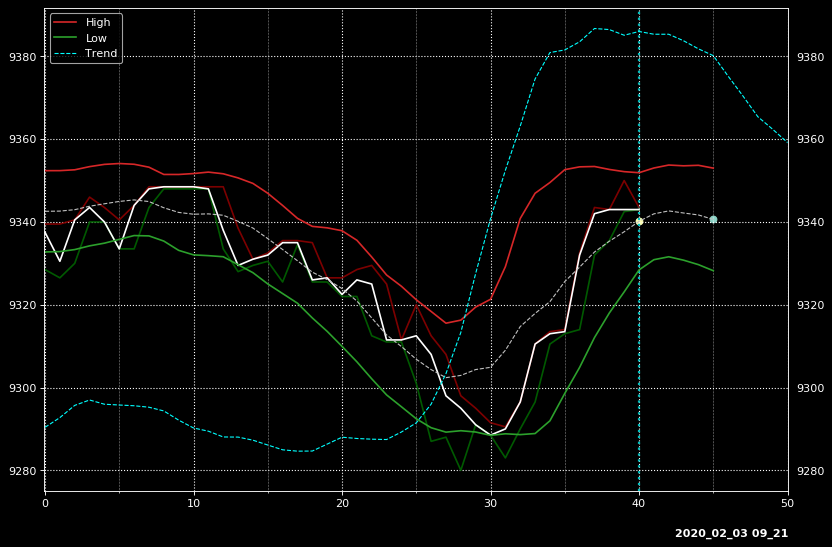

In [ ]:
    fig, ax = plt.subplots(figsize=(12,8))
    draw = 41
    pred_center_fast =  preds[-1,:2].mean()
    pred_center_slow = preds[-6,:2].mean()
    ax.scatter(45,pred_center_fast)
    ax.scatter(40,pred_center_slow)

    ax.plot(pred_df.high.values[-draw:], c='darkred', alpha=.9)
    ax.plot(pred_df.low.values[-draw:], c='darkgreen', alpha=.9)
    ax.plot(pred_df.close.values[-draw:], c='w')
    ax.plot(preds[-draw-5:,0], c='tab:red', label='High')
    ax.plot(preds[-draw-5:,1], c='tab:green', label='Low')
    ax.plot(preds[-draw-5:,:2].mean(axis=1), c='silver', linestyle='--', linewidth=1, label=None)
    ax.plot(preds[-draw-10:,2], c='cyan', linestyle='--', linewidth=1, label='Trend')

    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.grid(True,'minor', linestyle=':', linewidth=0.5)
    ax.xaxis.grid(True,'major', linestyle=':', linewidth=2)
    ax.grid(linestyle=':', linewidth=1)
    
    ax.legend(loc='upper left')
    ax.tick_params(labelright=True)

    # 시간
    now = datetime.now().strftime("%Y_%m_%d %H_%M")
    plt.figtext(0.9, 0.05, now, ha='right', va='bottom', weight='extra bold')

    ax.set_ylim(min(pred_df[-draw:].low.min(),preds[-draw:,2].min())-5, max(pred_df[-draw:].high.max(),preds[-draw:,2].max())+5)
    ax.vlines(draw-1, min(pred_df[-draw:].low.min(),preds[-draw:,2].min())-5, max(pred_df[-draw:].high.max(),preds[-draw:,2].max())+5, colors='c', linestyle=':', linewidth=2)
    plt.show()